# Empirical Finance Coursework 1
## Data import, transformations, and Exercise 1

In [1]:
!pip -q install matplotlib
!pip -q install matplotlib statsmodels

In [2]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import statsmodels.api as sm
print("matplotlib + statsmodels OK")

pd.set_option("display.float_format", lambda x: f"{x:,.4f}")

matplotlib + statsmodels OK


## Data helpers

In [3]:
def fred_series(series_id: str) -> pd.Series:
    # Download a FRED series as CSV (public, no API key needed)
    url = f"https://fred.stlouisfed.org/graph/fredgraph.csv?id={series_id}"
    df = pd.read_csv(url)

    # FRED usually uses 'observation_date' as the date column
    if "observation_date" in df.columns:
        date_col = "observation_date"
    elif "DATE" in df.columns:
        date_col = "DATE"
    else:
        raise ValueError(f"Cannot find a date column. Columns: {list(df.columns)[:10]}")

    df[date_col] = pd.to_datetime(df[date_col])

    # The value column is usually the series_id
    if series_id not in df.columns:
        raise ValueError(f"Cannot find column '{series_id}'. Columns: {list(df.columns)[:10]}")

    s = pd.to_numeric(df[series_id], errors="coerce")
    s.index = df[date_col]
    s.name = series_id
    return s

## Download raw data (Yahoo + FRED)

In [4]:
# --- Yahoo Finance: US stock index + GBPUSD ---
start = "1950-01-01"

us_stock = yf.download("^GSPC", start=start, auto_adjust=True, progress=False)["Close"]
gbpusd   = yf.download("GBPUSD=X", start=start, auto_adjust=True, progress=False)["Close"]

# Give clean names (useful for tables/plots)
us_stock.name = "us_stock"
gbpusd.name   = "gbpusd"

# --- FRED: yields (US/UK) + UK stock index proxy ---
us_short = fred_series("TB3MS").rename("us_short_yield")            # monthly
us_long  = fred_series("DGS10").rename("us_long_yield")             # daily

# UK short rate that goes to 2025 in your environment
uk_short = fred_series("IRSTCI01GBM156N").rename("uk_short_yield")   # monthly
uk_long  = fred_series("IRLTLT01GBM156N").rename("uk_long_yield")    # monthly

uk_stock = fred_series("SPASTT01GBM661N").rename("uk_stock")         # monthly

Quick sanity check:

In [5]:
def span(s: pd.Series, name: str):
    # Quick check of start/end dates and number of observations
    s2 = s.dropna()
    print(f"{name}: {s2.index.min().date()} -> {s2.index.max().date()} | N={len(s2)}")

span(us_stock, "us_stock (Yahoo)")
span(gbpusd,   "gbpusd (Yahoo)")

span(us_short, "us_short_yield (FRED)")
span(us_long,  "us_long_yield (FRED)")

span(uk_short, "uk_short_yield (FRED)")
span(uk_long,  "uk_long_yield (FRED)")

span(uk_stock, "uk_stock (FRED)")

us_stock (Yahoo): 1950-01-03 -> 2026-01-30 | N=19141
gbpusd (Yahoo): 2003-12-01 -> 2026-02-02 | N=5763
us_short_yield (FRED): 1934-01-01 -> 2025-12-01 | N=1104
us_long_yield (FRED): 1962-01-02 -> 2026-01-29 | N=16003
uk_short_yield (FRED): 1978-01-01 -> 2025-12-01 | N=576
uk_long_yield (FRED): 1960-01-01 -> 2025-12-01 | N=792
uk_stock (FRED): 1957-12-01 -> 2025-12-01 | N=817


## Build monthly dataset (month-end) and save

In [6]:
def to_monthly_last(s: pd.Series) -> pd.Series:
    # Convert any daily series to month-end by taking the last observation of each month
    s = s.dropna()
    s.index = pd.to_datetime(s.index)
    return s.resample("ME").last()  # 'ME' = Month End (new pandas convention)

data = pd.concat(
    [
        to_monthly_last(us_stock),
        to_monthly_last(uk_stock),
        to_monthly_last(us_short),
        to_monthly_last(us_long),
        to_monthly_last(uk_short),
        to_monthly_last(uk_long),
        to_monthly_last(gbpusd),
    ],
    axis=1,
    sort=False
).dropna()

# Rename Yahoo tickers to clean column names (safety net)
data = data.rename(columns={"^GSPC": "us_stock", "GBPUSD=X": "gbpusd"})

data.index.name = "date"

print("Common sample:", data.index.min().date(), "->", data.index.max().date())
print("N months:", len(data))
print("Columns:", list(data.columns))

data.head()

Common sample: 2003-12-31 -> 2025-12-31
N months: 265
Columns: ['us_stock', 'uk_stock', 'us_short_yield', 'us_long_yield', 'uk_short_yield', 'uk_long_yield', 'gbpusd']


,us_stock,uk_stock,us_short_yield,us_long_yield,uk_short_yield,uk_long_yield,gbpusd
date,,,,,,,
2003-12-31,"1,111.9200",66.6720,0.9000,4.2700,3.7778,4.8960,1.7888
2004-01-31,"1,131.1300",67.7967,0.8800,4.1600,3.7159,4.7875,1.8253
2004-02-29,"1,144.9399",67.3732,0.9300,3.9900,4.0873,4.8056,1.8695
2004-03-31,"1,126.2100",67.4276,0.9400,3.8600,3.9040,4.7088,1.8434
2004-04-30,"1,107.3000",68.4354,0.9400,4.5300,3.8914,4.9570,1.7786


We save the dataset:

In [7]:
# Save the clean monthly dataset for reproducibility
data.to_csv("empirical_coursework_monthly.csv")
print("Saved: empirical_coursework_monthly.csv")

Saved: empirical_coursework_monthly.csv


# Exercise 1 - Q1: Summary statistics and plots
## Transformations (returns + term spreads)

### Constructing the variables used in Exercise 1

We start from the raw long-span dataset and build a set of economically standard time-series for the US and UK.

**Equity and FX returns.**  
Because stock indices and exchange rates are non-stationary in levels, we work with *log returns* (in percent):
$$
r_t \;=\; 100 \times \Delta \ln(P_t)
\;=\; 100 \times \big(\ln P_t - \ln P_{t-1}\big).
$$
This transformation makes the series scale-free (comparable across time) and interpretable as an approximate monthly percentage change.

**Term spreads.**  
For each country, we also compute the slope of the yield curve as:
$$
ts_t \;=\; y^{L}_t - y^{S}_t,
$$
where $y^{L}_t$ is the long-term yield and $y^{S}_t$ is the short-term yield. The term spread is a key macro-finance state variable: a steeper curve is typically associated with easier future growth/monetary conditions, while an inverted curve often signals recession risk.

Finally, since returns require first differences, we drop the first observation created by the transformation. The resulting dataframe contains the core variables we will summarize and analyze in Questions 1–3.

In [8]:
df = data.copy()

# Log returns in % for stock indices and FX
df["r_us"] = 100 * np.log(df["us_stock"]).diff()
df["r_uk"] = 100 * np.log(df["uk_stock"]).diff()
df["r_fx"] = 100 * np.log(df["gbpusd"]).diff()

# Term spreads (long - short)
df["ts_us"] = df["us_long_yield"] - df["us_short_yield"]
df["ts_uk"] = df["uk_long_yield"] - df["uk_short_yield"]

# Drop first row (diff creates NaN)
df = df.dropna()

df[["r_us","r_uk","r_fx","us_short_yield","us_long_yield","ts_us","uk_short_yield","uk_long_yield","ts_uk"]].head()

,r_us,r_uk,r_fx,us_short_yield,us_long_yield,ts_us,uk_short_yield,uk_long_yield,ts_uk
date,,,,,,,,,
2004-01-31,1.7129,1.6728,2.0183,0.8800,4.1600,3.2800,3.7159,4.7875,1.0716
2004-02-29,1.2135,-0.6266,2.3940,0.9300,3.9900,3.0600,4.0873,4.8056,0.7183
2004-03-31,-1.6494,0.0808,-1.4071,0.9400,3.8600,2.9200,3.9040,4.7088,0.8048
2004-04-30,-1.6933,1.4835,-3.5778,0.9400,4.5300,3.5900,3.8914,4.9570,1.0656
2004-05-31,1.2011,-1.3251,2.9914,1.0200,4.6600,3.6400,4.2030,5.1118,0.9088


## (Optional) Simple vs log returns check

### Why we use log returns (and how different they are from simple returns)

We work with **log returns** (expressed in percent) as our baseline definition:
$$
r_t = 100 \cdot \Delta \ln(P_t)
    = 100 \left( \ln P_t - \ln P_{t-1} \right).
$$
Log returns are additive over time and are standard in empirical finance, especially when working with asset prices and exchange rates.

For comparison, **simple returns** are defined as:
$$
sr_t = 100 \left( \frac{P_t}{P_{t-1}} - 1 \right).
$$
At a monthly frequency, returns are typically small in magnitude, so a first-order approximation implies
$$
sr_t \approx r_t.
$$

We therefore compare simple and log returns by reporting:
- the maximum absolute difference $\max_t |sr_t - r_t|$,
- the correlation $\mathrm{corr}(sr_t, r_t)$,

for both the US stock index and the GBP/USD exchange rate. The results show that the two measures are almost perfectly correlated and numerically very close, confirming that the choice of log returns does not materially affect the empirical analysis.

In [9]:
# Compare simple vs log returns (monthly)

tmp = data[["us_stock", "gbpusd"]].copy()

# simple returns (%)
tmp["sr_us"] = 100 * tmp["us_stock"].pct_change()
tmp["sr_fx"] = 100 * tmp["gbpusd"].pct_change()

# log returns (%)
tmp["lr_us"] = 100 * np.log(tmp["us_stock"]).diff()
tmp["lr_fx"] = 100 * np.log(tmp["gbpusd"]).diff()

out = tmp[["sr_us","lr_us","sr_fx","lr_fx"]].dropna()

# quick numeric check: max absolute difference
diff_check = pd.Series({
    "max|sr-lr| US (%)": (out["sr_us"] - out["lr_us"]).abs().max(),
    "max|sr-lr| FX (%)": (out["sr_fx"] - out["lr_fx"]).abs().max(),
    "corr(sr,lr) US": out[["sr_us","lr_us"]].corr().iloc[0,1],
    "corr(sr,lr) FX": out[["sr_fx","lr_fx"]].corr().iloc[0,1],
})

diff_check

max|sr-lr| US (%)   1.6212
max|sr-lr| FX (%)   0.5149
corr(sr,lr) US      0.9993
corr(sr,lr) FX      0.9997
dtype: float64

### Interpretation: simple vs. log returns

The numerical comparison confirms that, at the monthly frequency, **simple and log returns are almost indistinguishable**.

- The **maximum absolute difference** between simple and log returns is modest (about $1.6\%$ for US stocks and $0.5\%$ for FX), and occurs during months with unusually large price movements.
- The **correlation between the two measures** is extremely high, with
$$
\mathrm{corr}(sr_t, r_t) \approx 0.999
$$
for both assets.

These results validate the standard approximation $sr_t \approx r_t$ for small returns and justify our use of **log returns** in the remainder of the analysis, without loss of economic or statistical information.

## Summary statistics (monthly + annualised returns)

### Summary statistics (monthly, common sample)

We start by documenting the empirical distribution of the core US/UK variables using a **common monthly sample**. Returns are computed as **log returns in percent**, i.e.
$$
r_t = 100\left(\ln P_t - \ln P_{t-1}\right),
$$
and term spreads are defined as
$$
ts_t = y_t^{L} - y_t^{S}.
$$

For each series, we report standard descriptive moments (mean, standard deviation, quantiles, skewness, kurtosis).  
For returns, we additionally provide approximate annualised moments under the usual i.i.d. scaling:
$$
\mu_{\text{ann}} \approx 12\,\mu_{\text{m}}, 
\qquad
\sigma_{\text{ann}} \approx \sqrt{12}\,\sigma_{\text{m}}.
$$

This section is purely descriptive: it sets the baseline stylised facts (location, dispersion, tails/asymmetry) that will guide our time-series modelling choices in Questions 2–3.

In [58]:
# Summary statistics (report-ready)

vars_ = [
    "r_us", "r_uk", "r_fx",
    "us_short_yield", "us_long_yield", "ts_us",
    "uk_short_yield", "uk_long_yield", "ts_uk"
]

# Sample info (common monthly sample)
print("Sample used:", df.index.min().date(), "->", df.index.max().date(), "| N =", len(df),"\n\n")

def summary_table(x: pd.DataFrame) -> pd.DataFrame:
    # Core stats (monthly, common sample)
    out = pd.DataFrame(index=x.columns)
    out["N"] = x.count()
    out["mean"] = x.mean()
    out["std"] = x.std()
    out["min"] = x.min()
    out["p05"] = x.quantile(0.05)
    out["p50"] = x.quantile(0.50)
    out["p95"] = x.quantile(0.95)
    out["max"] = x.max()
    out["skew"] = x.skew()
    out["kurt"] = x.kurtosis()
    return out

stats_main = summary_table(df[vars_]).round(4)

# Annualised stats for returns only (approx monthly -> annual)
ret_cols = ["r_us", "r_uk", "r_fx"]
stats_ann = pd.DataFrame(index=ret_cols)
stats_ann["ann_mean"] = (12 * df[ret_cols].mean()).round(4)
stats_ann["ann_std"]  = (np.sqrt(12) * df[ret_cols].std()).round(4)

print("\nMain summary statistics (monthly): \n\n")
display(stats_main)

print("\nAnnualised return moments (approx): \n\n")
display(stats_ann)

Sample used: 2004-01-31 -> 2025-12-31 | N = 264 



Main summary statistics (monthly): 




,N,mean,std,min,p05,p50,p95,max,skew,kurt
r_us,264,0.6884,4.2374,-18.5636,-7.4086,1.2528,6.6828,11.9421,-0.8149,1.9023
r_uk,264,0.3026,3.5195,-24.1927,-5.1059,0.6558,4.4971,8.5071,-2.2378,12.4423
r_fx,264,-0.1075,2.4879,-10.3227,-4.2757,-0.0977,3.5769,9.0386,-0.3753,1.6188
us_short_yield,264,1.6960,1.8653,0.0100,0.0200,0.9350,5.1570,5.3400,0.7451,-1.0030
us_long_yield,264,3.0134,1.1480,0.5500,1.3195,2.8800,4.6585,5.1500,-0.0564,-1.0703
ts_us,264,1.3174,1.2600,-1.5000,-0.9085,1.4300,3.2900,3.8000,-0.1819,-0.7328
uk_short_yield,264,2.0277,2.0984,0.0468,0.0539,0.5276,5.2812,5.9127,0.6032,-1.4997
uk_long_yield,264,2.9053,1.5102,0.2094,0.6238,2.9279,4.9501,5.4321,-0.1203,-1.4201
ts_uk,264,0.8776,1.1883,-1.3248,-0.8967,0.8050,3.2229,3.6281,0.4639,-0.4663



Annualised return moments (approx): 




,ann_mean,ann_std
r_us,8.2614,14.6788
r_uk,3.6314,12.1920
r_fx,-1.2904,8.6182


### Interpretation of the summary statistics (US/UK + FX)

**Sample and frequency.**  
We work with a common monthly sample from **2004-01 to 2025-12** ($N=264$), ensuring that all moments are directly comparable across series.

#### Returns: level, risk, and tail behaviour
- **US equity returns ($r_{us}$)** have a positive average monthly return ($\bar r \approx 0.69\%$), with sizeable volatility ($\sigma \approx 4.24\%$). The distribution is **left-skewed** (skew $\approx -0.81$) and **leptokurtic** (kurtosis $\approx 1.90$), indicating **fat left tails** and occasional large drawdowns (min $\approx -18.6\%$).
- **UK equity returns ($r_{uk}$)** show a lower average monthly return ($\bar r \approx 0.30\%$) and slightly lower volatility than the US ($\sigma \approx 3.52\%$), but the non-Gaussian features are much stronger: skewness $\approx -2.24$ and kurtosis $\approx 12.44$. This points to **rare but extreme negative shocks**, consistent with the very low minimum (min $\approx -24.2\%$).
- **FX returns ($r_{fx}$)** are close to zero on average ($\bar r \approx -0.11\%$) with lower volatility ($\sigma \approx 2.49\%$). Nonetheless, skewness and kurtosis remain non-zero, suggesting **non-normality** even in the exchange rate.

Using standard scaling, the approximate annualised moments are:
$$
\mu_{\text{ann}} \approx 12\mu_m,\qquad \sigma_{\text{ann}} \approx \sqrt{12}\sigma_m,
$$
giving **annualised means** of about **$8.26\%$ (US)**, **$3.63\%$ (UK)**, and **$-1.29\%$ (FX)**, and **annualised volatilities** around **$14.68\%$ (US)**, **$12.19\%$ (UK)**, and **$8.62\%$ (FX)**. These magnitudes are realistic for long-span monthly data and highlight the risk-return differences across assets.

#### Yields and term spreads: persistence and regimes
- **Short yields** have low minima near the zero lower bound (US min $\approx 0.01$, UK min $\approx 0.05$) and strong right tails (high $p95$ and max), consistent with pronounced **monetary policy regimes** over the sample. The positive skew in short rates reflects long periods of low rates punctuated by episodes of sharp tightening.
- **Long yields** are less dispersed than short yields (lower $\sigma$), and their

## (Optional) Robust dispersion for returns (median absolute deviation)

### Robust dispersion for returns: Median Absolute Deviation (MAD)

Because equity and FX returns are clearly non-Gaussian (skewness and excess kurtosis), the standard deviation can be overly influenced by extreme observations. To complement $\sigma$, we compute a **robust dispersion** measure: the **Median Absolute Deviation (MAD)** around the median.

For a return series $r_t$, define the median $m = \mathrm{median}(r_t)$. The MAD is:
$$
\mathrm{MAD} = \mathrm{median}\left(\lvert r_t - m \rvert\right).
$$

Under normality, a scaled version of MAD is comparable to the standard deviation:
$$
\tilde{\sigma} \approx 1.4826 \times \mathrm{MAD}.
$$

**Interpretation.**  
- $\tilde{\sigma}$ captures the *typical* monthly fluctuation of returns while being much less sensitive to tail events than $\sigma$.  
- When $\sigma \gg \tilde{\sigma}$, this is a clean signal that a few extreme months materially inflate the conventional volatility estimate—consistent with fat tails.  
- Reporting both $\sigma$ and $\tilde{\sigma}$ gives a more complete view of risk: *overall variability* versus *typical variability*.

In [11]:
# Robust dispersion (median absolute deviation)

median = df[["r_us", "r_uk", "r_fx"]].median()

mad_median = (df[["r_us", "r_uk", "r_fx"]]
              .sub(median)
              .abs()
              .median())

mad_scaled = 1.4826 * mad_median  # approx std if normal

mad_out = pd.DataFrame({
    "mad_median": mad_median,
    "scaled_mad": mad_scaled
}).round(4)

mad_out

,mad_median,scaled_mad
r_us,2.2468,3.3311
r_uk,1.7829,2.6433
r_fx,1.6012,2.3739


### Interpretation of MAD results (returns)

The robust volatility estimates (scaled MAD) are:

- $r_{us}$: $\tilde{\sigma} \approx 3.33\%$ per month  
- $r_{uk}$: $\tilde{\sigma} \approx 2.64\%$ per month  
- $r_{fx}$: $\tilde{\sigma} \approx 2.37\%$ per month

**Key takeaway.** The “typical” month-to-month variability is highest for US equity returns, then UK equity returns, and lowest for FX returns in this sample.

**Comparison with standard deviation.**  
Relative to the usual standard deviations (from the main summary table), the robust measures are systematically lower, especially for equities. This indicates that a non-trivial share of the conventional volatility is driven by **tail events / outliers**, consistent with the fat-tailed behavior already suggested by negative skewness and excess kurtosis.

We quickly export tables:

In [12]:
stats_main.to_csv("summary_stats_main.csv")
stats_ann.to_csv("summary_stats_annualised.csv")
mad_out.to_csv("robust_dispersion_returns.csv")
print("Saved CSV tables for Overleaf.")

Saved CSV tables for Overleaf.


## Q1 figures

### Visual inspection: levels vs. returns

We begin with simple time-series plots to separate **long-run movements** from **short-run fluctuations**.

- In **levels** (stock indices and GBPUSD), we typically expect strong persistence and possible regime changes over the sample, which often translates into near-unit-root behavior.
- In **returns** (log differences), we expect series that fluctuate around a stable mean with time-varying volatility, i.e. behavior closer to stationarity.

This visual check is not a formal test, but it helps us anticipate the modelling choices used later (unit-root testing and ARIMA specifications).

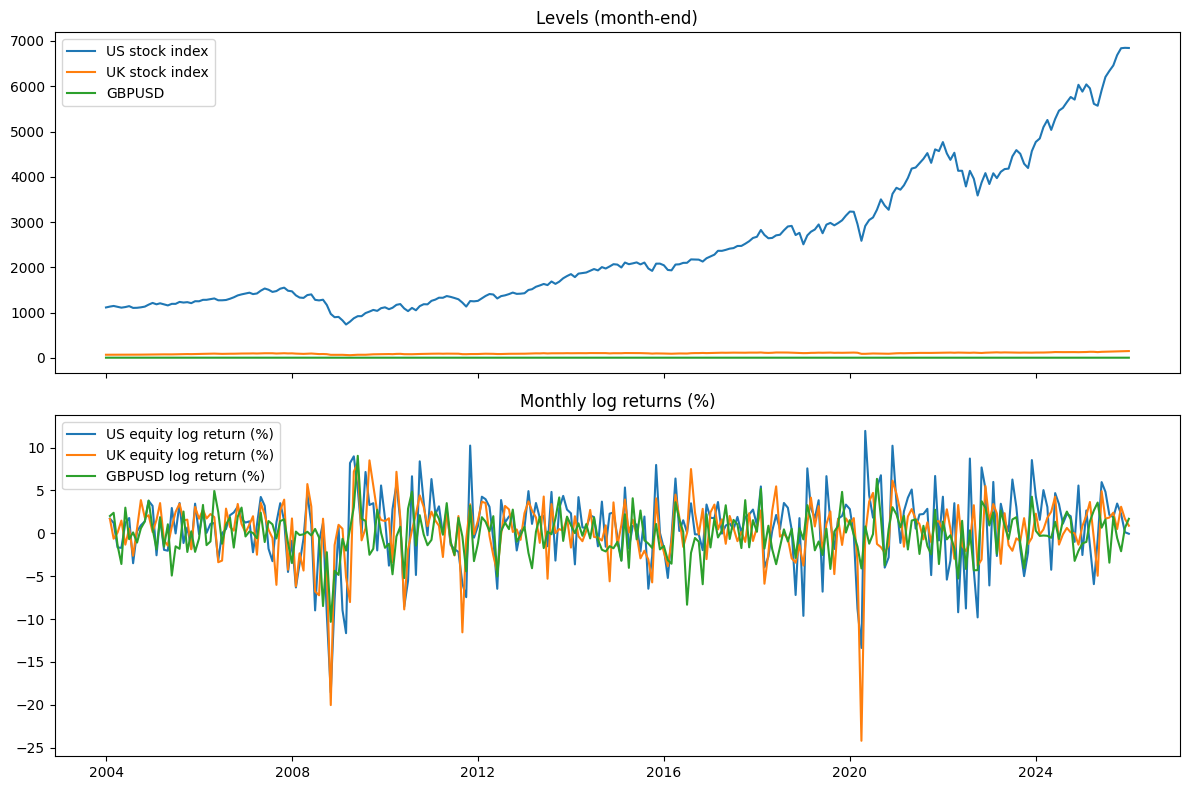

In [13]:
import matplotlib.pyplot as plt

# Time series plots (levels + returns)
fig, ax = plt.subplots(2, 1, figsize=(12, 8), sharex=True)

# Levels (indices + FX)
ax[0].plot(data.index, data["us_stock"], label="US stock index")
ax[0].plot(data.index, data["uk_stock"], label="UK stock index")
ax[0].plot(data.index, data["gbpusd"],   label="GBPUSD")
ax[0].set_title("Levels (month-end)")
ax[0].legend()

# Returns
ax[1].plot(df.index, df["r_us"], label="US equity log return (%)")
ax[1].plot(df.index, df["r_uk"], label="UK equity log return (%)")
ax[1].plot(df.index, df["r_fx"], label="GBPUSD log return (%)")
ax[1].set_title("Monthly log returns (%)")
ax[1].legend()

plt.tight_layout()
plt.show()

### Interpretation: levels vs. returns

The plots highlight a sharp contrast between **levels** and **returns**, with important implications for time-series modelling.

**Levels (top panel).**  
The US and UK stock indices display strong upward trends over the sample, interrupted by large drawdowns around major crises (notably 2008–2009 and 2020). This pronounced persistence and trending behaviour is characteristic of **non-stationary** processes, typically well approximated by unit-root dynamics.  
The GBPUSD exchange rate in levels is also highly persistent, with slow-moving swings rather than rapid mean reversion, again suggesting non-stationarity.

**Returns (bottom panel).**  
In contrast, monthly log returns for equities and the exchange rate fluctuate around a stable mean close to zero, with no visible long-run trend. Volatility is clearly **time-varying**, with pronounced clustering during crisis periods (e.g. the Global Financial Crisis and the COVID shock), but the mean dynamics appear relatively weak.

**Implications.**  
This visual evidence supports standard assumptions in empirical finance:
- Stock prices and exchange rates are better modelled as integrated processes in levels.
- Returns behave as approximately stationary series, $I(0)$, with limited linear predictability in the mean but strong heteroskedasticity in volatility.

These observations motivate the subsequent formal stationarity tests and the use of ARIMA models with $d=0$ for returns and $d=1$ for yield or level-based variables.

### Distributional diagnostics: return histograms

To complement the summary statistics, we visualize the **empirical distribution** of monthly log returns for US equities, UK equities, and GBPUSD. Histograms provide a quick check for departures from Gaussianity (e.g., skewness, excess kurtosis / fat tails), which is particularly relevant in financial data and helps interpret later normality diagnostics (e.g., Jarque–Bera) and volatility modelling choices.

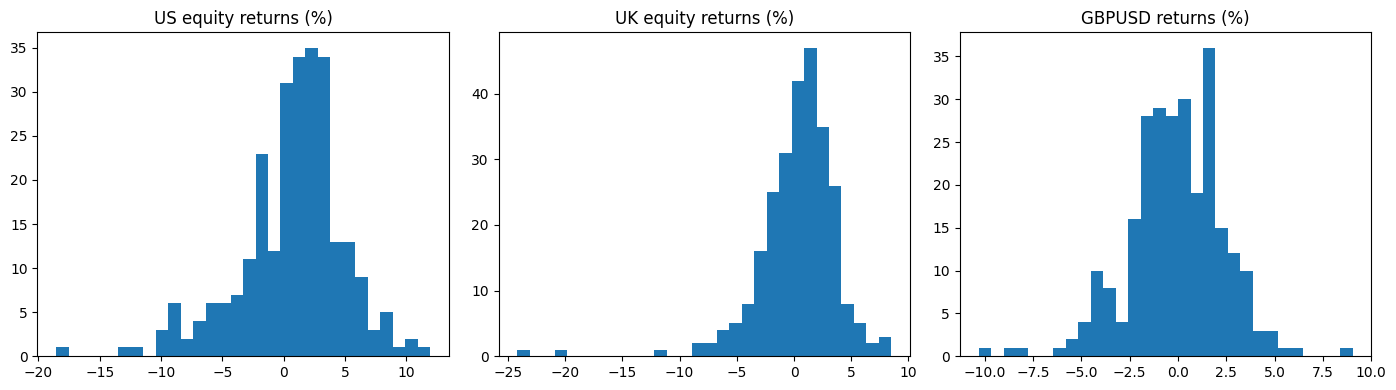

In [14]:
# Histograms (returns)
fig, ax = plt.subplots(1, 3, figsize=(14, 4))

ax[0].hist(df["r_us"].dropna(), bins=30)
ax[0].set_title("US equity returns (%)")

ax[1].hist(df["r_uk"].dropna(), bins=30)
ax[1].set_title("UK equity returns (%)")

ax[2].hist(df["r_fx"].dropna(), bins=30)
ax[2].set_title("GBPUSD returns (%)")

plt.tight_layout()
plt.show()

The histograms of monthly log returns reveal several stylised facts commonly observed in financial markets.

- **Non-Gaussian features.**  
  All three return series display departures from normality, with distributions that are more peaked around zero and with heavier tails than a Gaussian benchmark. This is consistent with the positive excess kurtosis observed in the summary statistics and later confirmed by Jarque–Bera tests.

- **Asymmetry and downside risk.**  
  Equity returns, in particular for the UK market, exhibit noticeable left-tail events, reflecting large negative returns during stress periods (e.g. the Global Financial Crisis and the COVID-19 shock). This highlights the relevance of downside risk for investors and the limitations of symmetric Gaussian assumptions.

- **FX returns.**  
  GBPUSD returns appear more tightly concentrated around zero, with lower dispersion than equity returns, but still display fat tails. This suggests that while FX markets are less volatile on average, extreme movements remain economically significant.

Overall, these distributional features motivate the use of robust inference for mean dynamics and, for some series, volatility models that allow for conditional heteroskedasticity and fat tails in later stages of the analysis.

### Boxplots: distribution summary for returns and term spreads

To complement the summary statistics and histograms, we use boxplots to visualise the distribution of monthly **returns** $(r_{us}, r_{uk}, r_{fx})$ and **term spreads** $(ts_{us}, ts_{uk})$.

- **Returns: dispersion and outliers.**  
  The equity return distributions (especially $r_{us}$ and $r_{uk}$) show relatively wide interquartile ranges and several extreme observations. This highlights the presence of tail events and reinforces that volatility is not fully captured by a single “typical” dispersion measure.

- **FX returns: comparatively tighter but still heavy-tailed.**  
  The GBPUSD return series tends to have a narrower central box than equity returns, but still exhibits outliers, consistent with occasional large exchange-rate moves.

- **Term spreads: persistence and asymmetry.**  
  Boxplots for $ts_{us}$ and $ts_{uk}$ typically show a more compact distribution than equity returns (since spreads move in levels rather than in % returns), but can still display asymmetric tails. Economically, extreme spread values can correspond to unusual monetary-policy regimes or stress episodes in bond markets.

Overall, the boxplots provide a quick robustness check: the central tendency (median) and dispersion (IQR) differ substantially across assets, and outliers are an important empirical feature—especially for equity returns—motivating robust inference and careful interpretation of tail risk.

/var/folders/9q/bytq5gl17h3dwptwm8jtkd8h0000gn/T/ipykernel_93646/559436855.py:5: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([x[c] for c in x.columns], labels=x.columns)


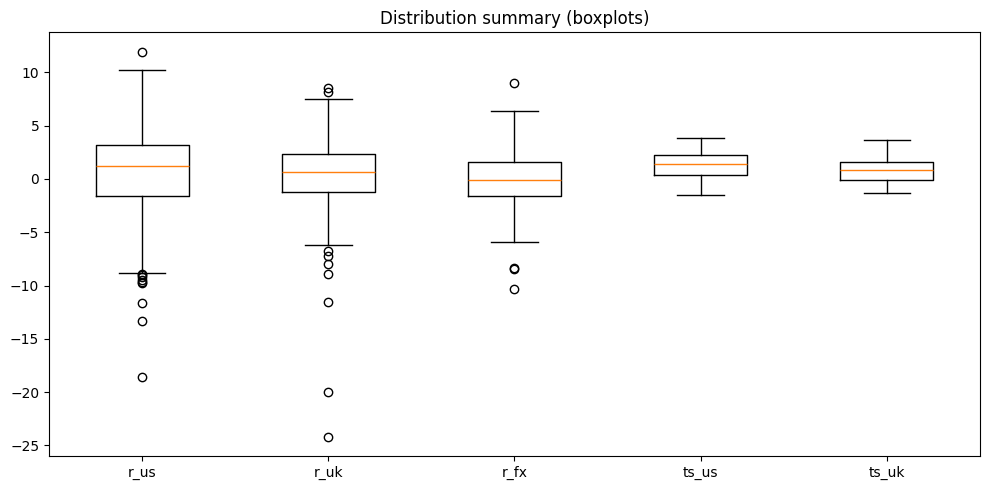

In [15]:
# Boxplots (returns + spreads)
x = df[["r_us", "r_uk", "r_fx", "ts_us", "ts_uk"]].dropna()

plt.figure(figsize=(10, 5))
plt.boxplot([x[c] for c in x.columns], labels=x.columns)
plt.title("Distribution summary (boxplots)")
plt.tight_layout()
plt.show()

The boxplots provide a compact comparison of the **distributional properties** across assets, highlighting differences in dispersion, asymmetry, and tail behaviour.

- **Equity returns ($r_{us}$, $r_{uk}$).**  
  Both return series display wide interquartile ranges and numerous outliers on both sides, with particularly extreme negative observations. This reflects the presence of **large downside risk** and **fat tails**, especially pronounced for UK equity returns. The median is slightly positive in both cases, consistent with positive average returns over the sample.

- **Exchange-rate returns ($r_{fx}$).**  
  FX returns exhibit a somewhat tighter central distribution than equities, but still show several large outliers. This indicates that while typical monthly FX movements are smaller, **occasional sharp depreciations/appreciations** remain an important feature.

- **Term spreads ($ts_{us}$, $ts_{uk}$).**  
  The spreads have much narrower boxes, reflecting lower short-run volatility compared to returns. However, the distributions are not perfectly symmetric and still exhibit outliers, which can be associated with **unusual monetary-policy regimes or stress episodes** in bond markets.

Overall, the boxplots confirm that **returns are far more volatile and heavy-tailed than term spreads**, motivating robust inference and careful modelling of tail risk in subsequent time-series analysis.

### Yield curves over time (US vs UK)

We plot short- and long-term government yields for the US and the UK to get a clean picture of the **rate environment** our sample lives in.

- **Rates move in regimes, not day-to-day noise.**  
  Unlike returns, yields drift slowly and tend to stay high or low for long stretches. That kind of “sticky” behaviour is exactly what we usually associate with very persistent processes (often close to $I(1)$ in levels), and it’s why differencing (or at least testing for it) is typically needed before we fit short-run ARMA dynamics.

- **Short and long rates co-move within each country.**  
  The two lines generally travel together, which is what we would expect if the whole curve is driven by common macro forces (inflation expectations, growth outlook, and the policy stance), with the long end reacting more smoothly.

- **The slope is clearly time-varying.**  
  The distance between long and short yields—the term spread—widens and compresses over time. When the short rate rises toward the long rate, the curve flattens (and sometimes inverts), which is often interpreted as markets pricing tighter policy and/or weaker future activity.

- **US vs UK: similar structure, different timing.**  
  The broad story is the same (persistent cycles and curve-shape changes), but the level and turning points differ across countries, consistent with different monetary-policy paths and inflation episodes.

Overall, these plots justify treating yields (and the spread) as slow-moving state variables, and they foreshadow why we handle them differently from returns in the time-series specification step.

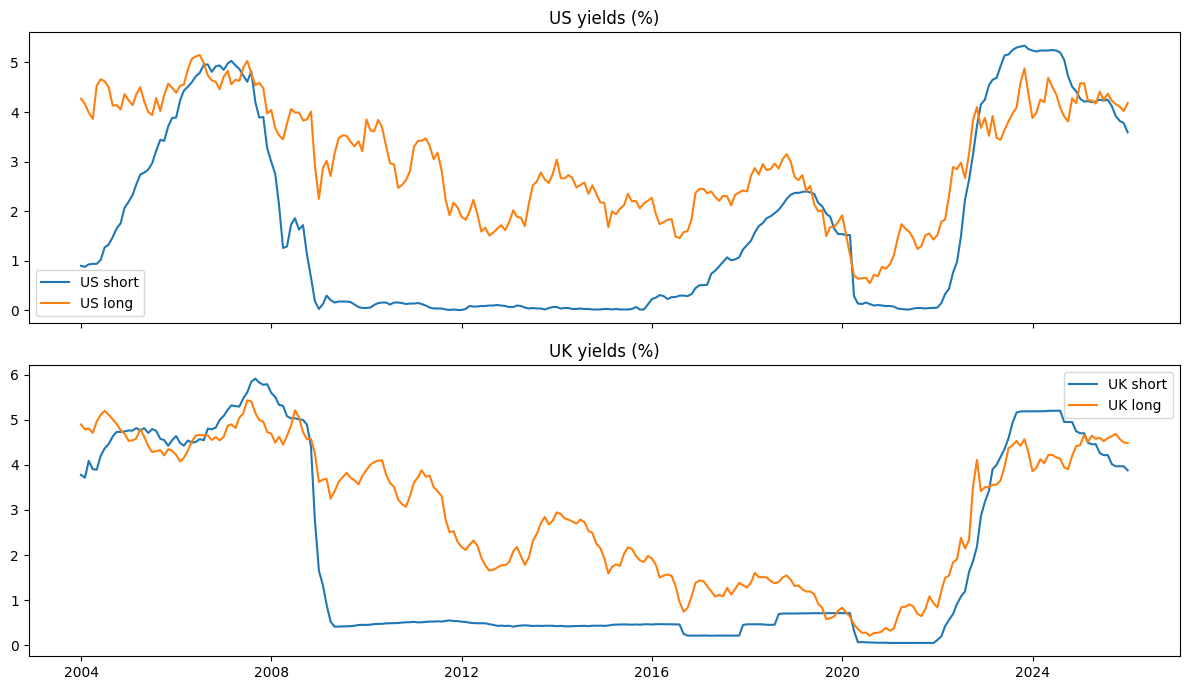

In [16]:
# Yields over time (US + UK)
fig, ax = plt.subplots(2, 1, figsize=(12, 7), sharex=True)

ax[0].plot(data.index, data["us_short_yield"], label="US short")
ax[0].plot(data.index, data["us_long_yield"],  label="US long")
ax[0].set_title("US yields (%)")
ax[0].legend()

ax[1].plot(data.index, data["uk_short_yield"], label="UK short")
ax[1].plot(data.index, data["uk_long_yield"],  label="UK long")
ax[1].set_title("UK yields (%)")
ax[1].legend()

plt.tight_layout()
plt.show()

The evolution of short- and long-term yields in both the US and the UK exhibits a high degree of persistence, with interest rates moving in long, smooth cycles rather than fluctuating around a fixed mean. This visual evidence already suggests that yields in levels behave as highly persistent, near–unit-root processes, which is consistent with the formal stationarity tests discussed later.

Short-term yields are clearly dominated by monetary policy. In both countries, they drop sharply during major stress episodes—most notably around the Global Financial Crisis and again during the COVID period—and then remain close to the effective lower bound for several years. The sharp and rapid increase observed after 2021 reflects a regime shift toward aggressive monetary tightening in response to rising inflation. These movements underline the central role of policy decisions in shaping the short end of the yield curve.

Long-term yields display smoother dynamics. While they broadly follow the same cyclical patterns as short rates, their adjustments are more gradual, reflecting the fact that long yields incorporate expectations about future short rates as well as term premia. As a result, they do not react as abruptly to policy changes, but they still co-move with the overall monetary and macroeconomic environment.

The distance between short and long yields varies substantially over time, alternating between periods of a steep yield curve and episodes in which the curve becomes relatively flat or even close to inversion. This time variation motivates the analysis of the term spread as a separate variable, as it captures information about economic expectations beyond the level of interest rates.

Finally, while the US and UK yield curves share the same broad structure and react to common global shocks, there are noticeable differences in timing and amplitude. These reflect country-specific monetary policy frameworks and economic conditions, even though the underlying dynamics are qualitatively similar.

Taken together, these patterns provide strong economic support for modelling yields as non-stationary processes in levels and for focusing on their changes when specifying time-series models.

### Cross-sectional dependence: correlation matrix (US variables)

As a complement to the univariate summary statistics, we report the contemporaneous correlation matrix for the US-focused variables:
$$(r_{us},\ r_{fx},\ y^{S}_{us},\ y^{L}_{us},\ ts_{us}).$$

This is not meant to establish causality, but rather to provide a compact picture of how these macro-financial quantities tend to co-move at the monthly frequency. In particular:

- We typically expect a strong positive association between $y^{L}_{us}$ and $y^{S}_{us}$, since both are driven by common monetary and macroeconomic forces.
- Since the term spread is defined as $ts_{us}=y^{L}_{us}-y^{S}_{us}$, mechanical relationships follow: $ts_{us}$ should be positively related to $y^{L}_{us}$ and negatively related to $y^{S}_{us}$ (the exact magnitudes depend on which end of the curve moves more over the sample).
- Correlations between returns $(r_{us}, r_{fx})$ and yield variables are often weaker and more unstable, because returns are closer to $I(0)$ “shock-like” processes while yields are highly persistent in levels. Any noticeable correlation here is still economically interesting (e.g., risk-on/risk-off episodes), but we interpret it cautiously.

Overall, this matrix serves as a useful descriptive snapshot and helps anchor the later modelling choices (in particular, the fact that yields share strong common dynamics, while returns are much less tightly linked in contemporaneous correlation terms).

In [17]:
# Correlation matrix (US-focused variables)
us_vars = ["r_us", "r_fx", "us_short_yield", "us_long_yield", "ts_us"]
corr_us = df[us_vars].corr()

corr_us.round(4)

,r_us,r_fx,us_short_yield,us_long_yield,ts_us
r_us,1.0000,0.4703,0.0240,-0.0526,-0.0834
r_fx,0.4703,1.0000,0.0930,0.0593,-0.0837
us_short_yield,0.0240,0.0930,1.0000,0.7494,-0.7976
us_long_yield,-0.0526,0.0593,0.7494,1.0000,-0.1984
ts_us,-0.0834,-0.0837,-0.7976,-0.1984,1.0000


The main patterns are economically coherent:

**1) Equity returns and FX returns co-move meaningfully.**  
The correlation between $r_{us}$ and $r_{fx}$ is $0.47$, which is fairly large at the monthly frequency. This suggests that months with strong US equity performance tend to coincide with systematic moves in GBPUSD returns (a “global risk” component). The sign is sample-dependent and reflects how $r_{fx}$ is defined (GBPUSD log return): we simply read this as evidence of a shared risk-on/risk-off factor across asset classes.

**2) The yield curve is highly internally correlated.**  
Short and long US yields have a correlation of $0.75$, indicating a strong common level factor in the term structure: when the curve shifts, it tends to shift together, even if not one-for-one.

**3) The term spread behaves exactly as it should mechanically.**  
Recall $ts_{us} = y^{L}_{us} - y^{S}_{us}$. The spread is strongly **negatively** correlated with the short rate ($-0.80$): when short rates rise, the curve tends to flatten (the short end moves more than the long end). The spread is only mildly negatively correlated with long yields ($-0.20$), which is consistent with the long end being less tightly tied to short-run policy moves over the sample.

**4) Returns are almost uncorrelated with yields in levels.**  
Correlations between $r_{us}$ and yields are close to zero (e.g., $0.02$ with $y^{S}_{us}$, $-0.05$ with $y^{L}_{us}$). This is a typical monthly-data result: returns are closer to $I(0)$ shocks, while yields in levels are highly persistent ($I(1)$-like), so contemporaneous correlations are often small and not very informative.

Overall, the correlation matrix mainly reinforces two messages: (i) yields share strong common dynamics (curve-level effects), and (ii) the term spread is largely driven by movements at the short end (flattening/steepening episodes), while returns live on a different (more shock-driven) time-series scale.

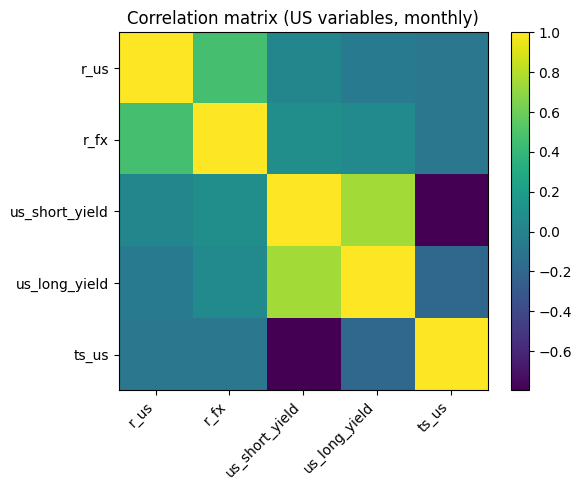

In [18]:
# Simple heatmap for correlation matrix

plt.figure(figsize=(6,5))
plt.imshow(corr_us, aspect="auto")
plt.xticks(range(len(corr_us.columns)), corr_us.columns, rotation=45, ha="right")
plt.yticks(range(len(corr_us.index)), corr_us.index)
plt.title("Correlation matrix (US variables, monthly)")
plt.colorbar()
plt.tight_layout()
plt.show()

### Robust distributional shape: skewness and kurtosis based on quantiles

Beyond standard moment-based measures of skewness and kurtosis, we also compute **robust distributional shape statistics** based on quantiles. These measures are less sensitive to extreme observations and are therefore well suited for financial time series, which are known to exhibit fat tails and occasional large shocks.

We consider two complementary indicators.

**Bowley skewness**, defined using quartiles,
$$
\text{Skew}_{\text{Bowley}}
= \frac{Q_{0.75} + Q_{0.25} - 2Q_{0.50}}{Q_{0.75} - Q_{0.25}},
$$
captures distributional asymmetry around the median in a robust way.

**Moors kurtosis**, based on octiles,
$$
\text{Kurt}_{\text{Moors}}
= \frac{(P_{0.875}-P_{0.625}) + (P_{0.375}-P_{0.125})}{P_{0.75}-P_{0.25}},
$$
measures tail thickness relative to the interquartile range without relying on fourth moments.

Together, these robust statistics complement conventional skewness and kurtosis by providing a clearer picture of distributional asymmetry and tail behavior when extreme values are present.

In [19]:
# Robust skewness/kurtosis using quantiles (Bowley skewness + Moors kurtosis)

def bowley_skew(x: pd.Series) -> float:
    # Bowley skewness = (Q3 + Q1 - 2*Q2) / (Q3 - Q1)
    q1, q2, q3 = x.quantile([0.25, 0.50, 0.75])
    denom = (q3 - q1)
    return np.nan if denom == 0 else (q3 + q1 - 2*q2) / denom

def moors_kurt(x: pd.Series) -> float:
    # Moors kurtosis uses octiles:
    # ((P87.5 - P62.5) + (P37.5 - P12.5)) / (P75 - P25)
    p = x.quantile([0.125, 0.375, 0.625, 0.875, 0.25, 0.75])
    p125, p375, p625, p875, p25, p75 = p.loc[0.125], p.loc[0.375], p.loc[0.625], p.loc[0.875], p.loc[0.25], p.loc[0.75]
    denom = (p75 - p25)
    return np.nan if denom == 0 else ((p875 - p625) + (p375 - p125)) / denom

robust = pd.DataFrame(index=vars_)
robust["bowley_skew"] = [bowley_skew(df[v].dropna()) for v in vars_]
robust["moors_kurt"]  = [moors_kurt(df[v].dropna()) for v in vars_]

robust.round(4)

,bowley_skew,moors_kurt
r_us,-0.1793,1.3757
r_uk,-0.0586,1.2604
r_fx,0.0781,1.1358
us_short_yield,0.4747,0.9060
us_long_yield,0.2072,0.8990
ts_us,-0.1410,1.0771
uk_short_yield,0.9526,0.8653
uk_long_yield,0.0103,0.6444
ts_uk,-0.0745,1.2935


The Bowley skewness and Moors kurtosis confirm several stylised facts, while separating what comes from *systematic asymmetry* versus *tail events*.

**Returns ($r_{us}$, $r_{uk}$, $r_{fx}$).**  
Bowley skewness is slightly negative for equity returns ($r_{us}=-0.179$, $r_{uk}=-0.059$), suggesting mild left-asymmetry: extreme downside months tend to be more pronounced than extreme upside months. FX returns are close to symmetric ($r_{fx}=0.078$).  
Moors kurtosis is relatively elevated for returns (roughly $1.14$–$1.38$), consistent with **fat tails** and occasional large moves, even when measured robustly (i.e., not driven by a handful of outliers).

**Yields ($y^{S}$ and $y^{L}$).**  
Short yields display clear positive skewness (US: $0.475$, UK: $0.953$). This is economically intuitive: yields are bounded below (near the effective lower bound) but can jump upward when monetary policy tightens, creating right-skewed level distributions. Long yields are also mildly right-skewed (US: $0.207$) and nearly symmetric for the UK ($0.010$).  
Moors kurtosis for yields is below (or around) 1 in most cases (US short/long: $\approx 0.90$, UK short: $0.87$, UK long: $0.64$), indicating **less tail thickness** in levels than in returns, consistent with smoother dynamics and policy/term-structure inertia.

**Term spreads ($ts_{us}$, $ts_{uk}$).**  
Both spreads are slightly left-skewed (US: $-0.141$, UK: $-0.075$), consistent with episodes of curve flattening or inversion generating more pronounced negative realizations. The UK spread shows relatively high Moors kurtosis ($1.294$), suggesting **fatter tails** than the US spread ($1.077$), i.e., more mass in the extremes relative to the IQR.

Overall, these robust shape measures broadly agree with the standard-moment picture: returns exhibit heavier tails and some downside asymmetry, while yield levels are more asymmetric (especially short rates) but typically less tail-heavy.

# Exercise 1 — Q2: ACF / PACF (monthly, US-focused)
We inspect serial dependence using ACF/PACF and confirm with Ljung–Box tests.

In [20]:
import matplotlib.pyplot as plt

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.diagnostic import acorr_ljungbox

## Q2.1 - ACF/PACF helper (one panel per series)

In [21]:
def acf_pacf_panel(series: pd.Series, title: str, lags: int = 24):
    # Simple ACF/PACF panel for one series (monthly data -> 24 lags = 2 years)
    x = series.dropna()

    fig, ax = plt.subplots(1, 2, figsize=(12, 4))

    plot_acf(x, lags=lags, ax=ax[0], zero=False)
    ax[0].set_title(f"ACF — {title}")

    plot_pacf(x, lags=lags, ax=ax[1], zero=False, method="ywm")
    ax[1].set_title(f"PACF — {title}")

    plt.tight_layout()
    plt.show()

## Q2.2 - ACF/PACF in levels (US-focused variables)

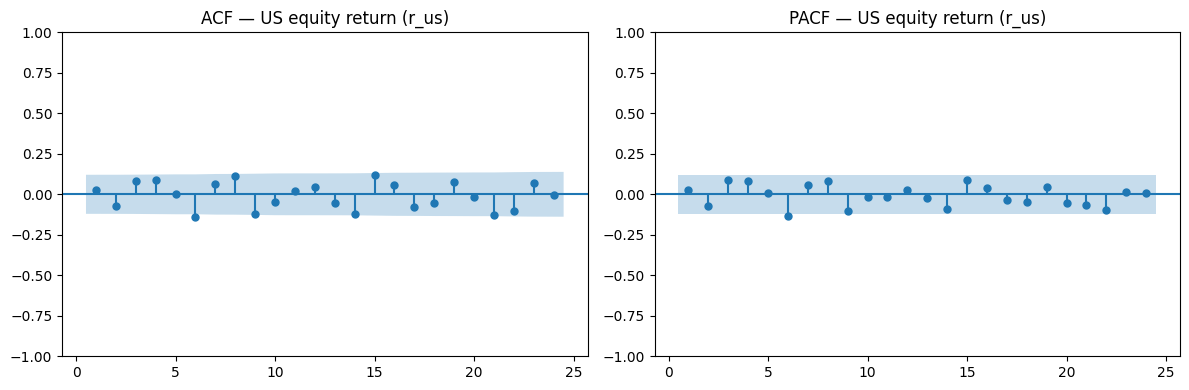

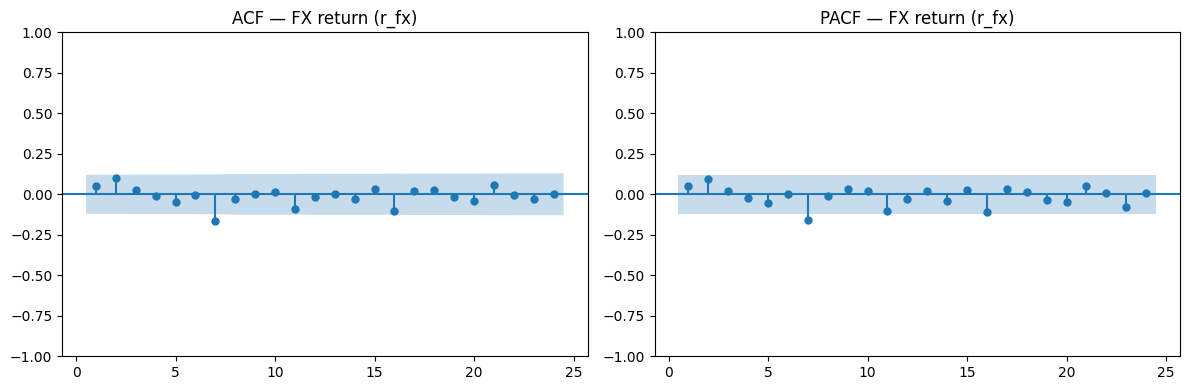

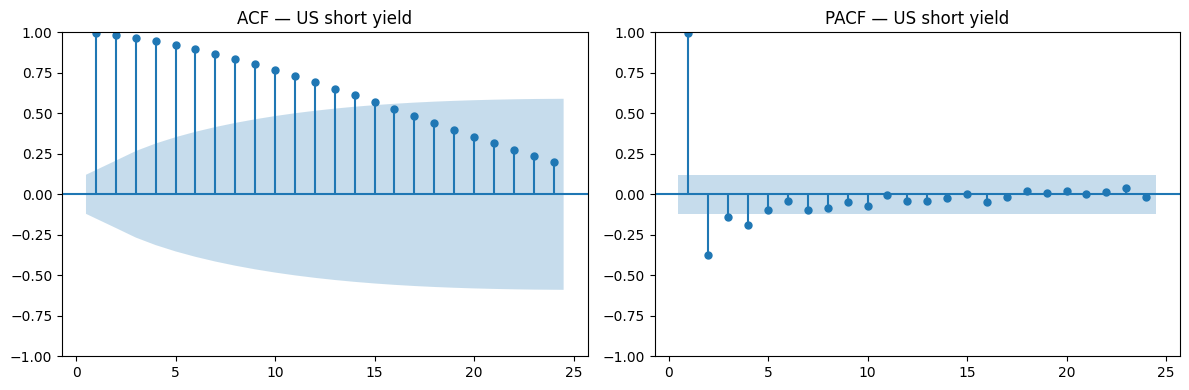

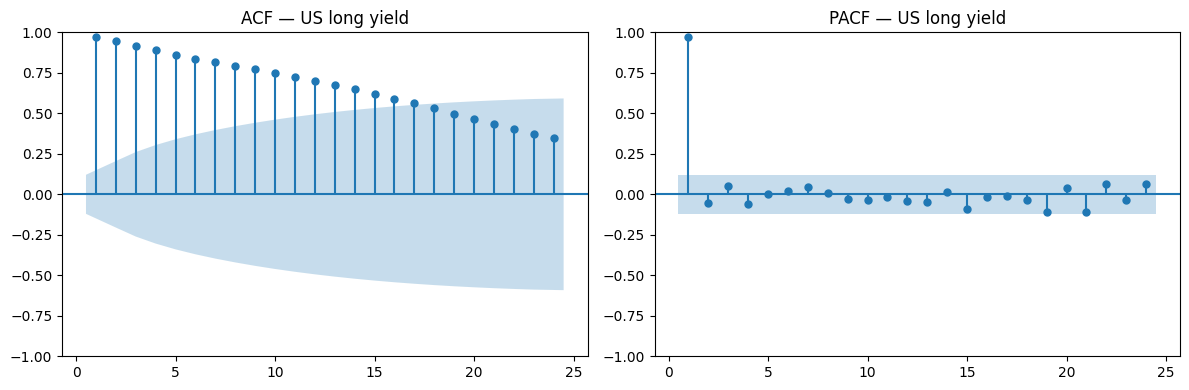

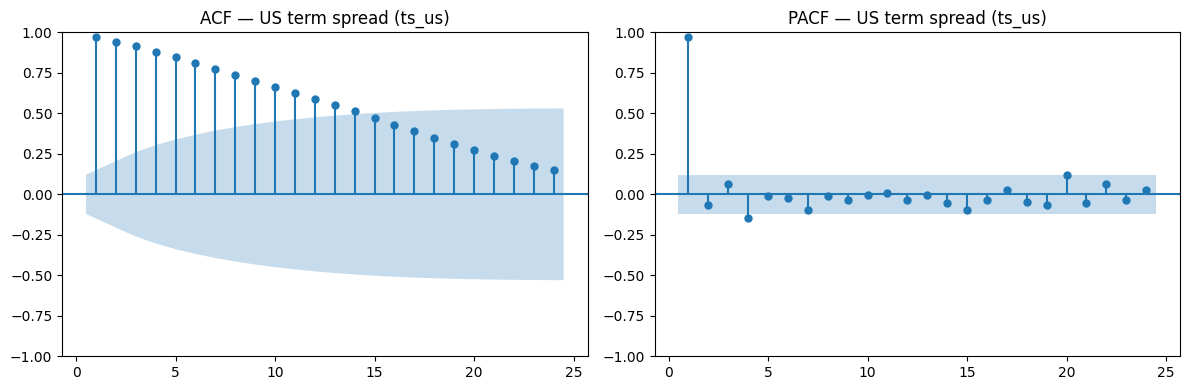

In [22]:
# US variables used in Exercise 1 (monthly sample)
series_us = {
    "US equity return (r_us)": df["r_us"],
    "FX return (r_fx)": df["r_fx"],
    "US short yield": df["us_short_yield"],
    "US long yield": df["us_long_yield"],
    "US term spread (ts_us)": df["ts_us"],
}

L = 24  # monthly: 24 lags = 2 years

for name, s in series_us.items():
    acf_pacf_panel(s, name, lags=L)

## Q2.3 - ACF/PACF of first differences (yields)
In levels, yields are typically highly persistent. First differences often reduce persistence and help assess stationarity.

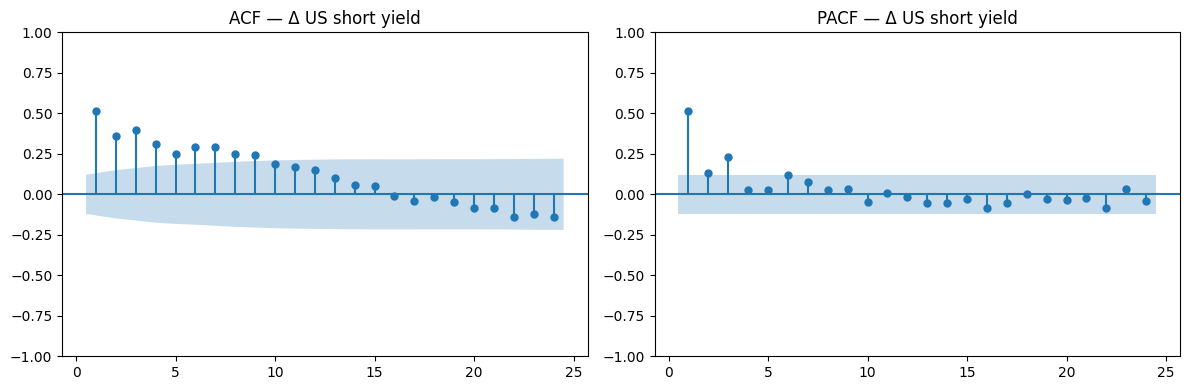

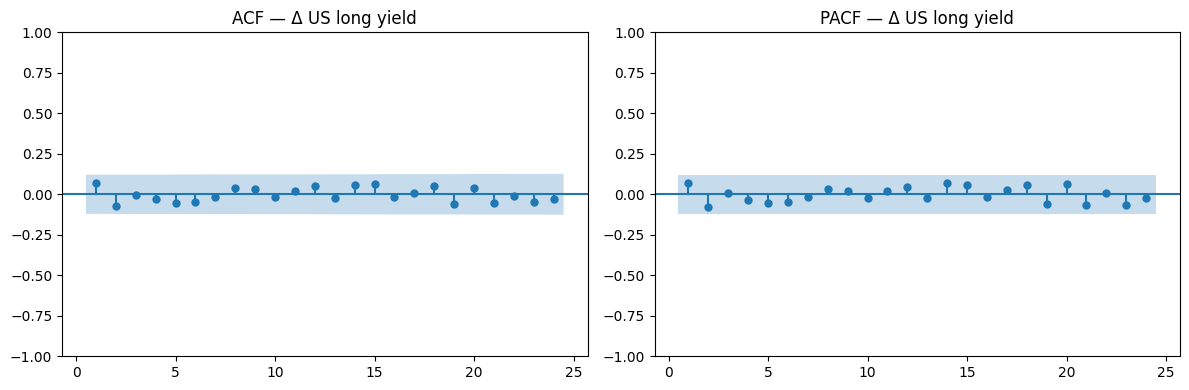

In [23]:
# First differences of yields (do not modify df)
d_us_short = df["us_short_yield"].diff()
d_us_long  = df["us_long_yield"].diff()

acf_pacf_panel(d_us_short, "Δ US short yield", lags=24)
acf_pacf_panel(d_us_long,  "Δ US long yield",  lags=24)

## Q2.3bis - Stationarity check (ADF test)
We complement the ACF/PACF evidence with Augmented Dickey-Fuller tests on levels and first differences.

In [24]:
from statsmodels.tsa.stattools import adfuller

def adf_test(series: pd.Series, name: str):
    x = series.dropna()
    stat, pval, _, _, crit, _ = adfuller(x, autolag="AIC")
    return pd.Series({
        "ADF stat": stat,
        "p-value": pval,
        "1%": crit["1%"],
        "5%": crit["5%"],
        "10%": crit["10%"]
    }, name=name)

adf_results = pd.concat([
    adf_test(df["us_short_yield"], "us_short_yield (level)"),
    adf_test(df["us_long_yield"],  "us_long_yield (level)"),
    adf_test(df["ts_us"],          "ts_us (level)"),
    adf_test(d_us_short,           "Δ us_short_yield"),
    adf_test(d_us_long,            "Δ us_long_yield"),
], axis=1).T.round(4)

adf_results

,ADF stat,p-value,1%,5%,10%
us_short_yield (level),-2.7239,0.0700,-3.4562,-2.8729,-2.5728
us_long_yield (level),-1.7536,0.4037,-3.4555,-2.8726,-2.5727
ts_us (level),-2.0455,0.2670,-3.4555,-2.8726,-2.5727
Δ us_short_yield,-4.9658,0.0000,-3.4558,-2.8727,-2.5727
Δ us_long_yield,-15.0274,0.0000,-3.4556,-2.8726,-2.5727


## Q2.4 - Ljung–Box tests (overall autocorrelation)
We test the joint null of no autocorrelation up to 12 and 24 months.

In [25]:
# Format helper for p-values (used for all LB tables below)
def fmt_p(p):
    return "< 0.0001" if p < 1e-4 else f"{p:.4f}"

alpha = 0.05
test_vars = ["r_us", "r_fx", "us_short_yield", "us_long_yield", "ts_us"]

lb_rows = []
for v in test_vars:
    x = df[v].dropna()
    res = acorr_ljungbox(x, lags=[12, 24], return_df=True)
    tmp = res.copy()
    tmp["variable"] = v
    tmp["lag"] = tmp.index
    lb_rows.append(tmp[["variable", "lag", "lb_stat", "lb_pvalue"]])

lb = pd.concat(lb_rows, ignore_index=True)

lb_pvals = lb.pivot(index="variable", columns="lag", values="lb_pvalue")
lb_pvals = lb_pvals.rename(columns={12: "pvalue (12)", 24: "pvalue (24)"})

decision = (lb_pvals < alpha).replace({True: "Reject H0", False: "Fail to reject"})
decision = decision.rename(columns={"pvalue (12)": "decision (12)", "pvalue (24)": "decision (24)"})

lb_out = pd.concat([lb_pvals, decision], axis=1)
lb_out = lb_out.loc[["r_fx", "r_us", "ts_us", "us_long_yield", "us_short_yield"]]

lb_out_fmt = lb_out.copy()
lb_out_fmt["pvalue (12)"] = lb_out_fmt["pvalue (12)"].apply(fmt_p)
lb_out_fmt["pvalue (24)"] = lb_out_fmt["pvalue (24)"].apply(fmt_p)

display(lb_out_fmt)
print(f"Decision rule: reject H0 of no autocorrelation if p-value < {alpha}")

lag,pvalue (12),pvalue (24),decision (12),decision (24)
variable,,,,
r_fx,0.2814,0.7055,Fail to reject,Fail to reject
r_us,0.0563,0.0072,Fail to reject,Reject H0
ts_us,< 0.0001,< 0.0001,Reject H0,Reject H0
us_long_yield,< 0.0001,< 0.0001,Reject H0,Reject H0
us_short_yield,< 0.0001,< 0.0001,Reject H0,Reject H0


Decision rule: reject H0 of no autocorrelation if p-value < 0.05


Interpretation: low p-values suggest rejecting the null of no autocorrelation up to the chosen lag.

Takeaways:
- r_fx shows no evidence of serial correlation (LB p-values > 0.1).
- r_us shows weak but statistically significant serial dependence when testing jointly up to 24 lags.
- yields and the term spread are highly persistent (very small LB p-values), consistent with slow-decaying ACF.

## Q2.5 - Volatility clustering proxy: squared returns
Returns may show weak serial correlation in the mean, while squared returns often display persistence (time-varying volatility).

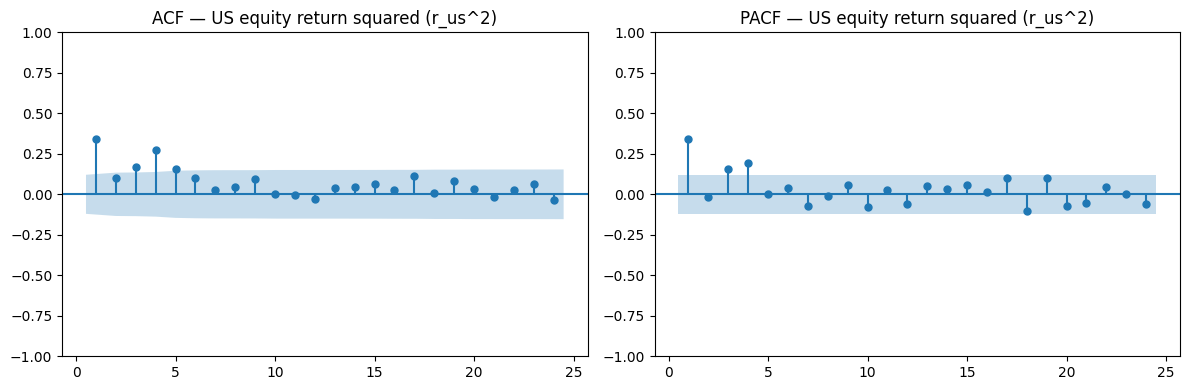

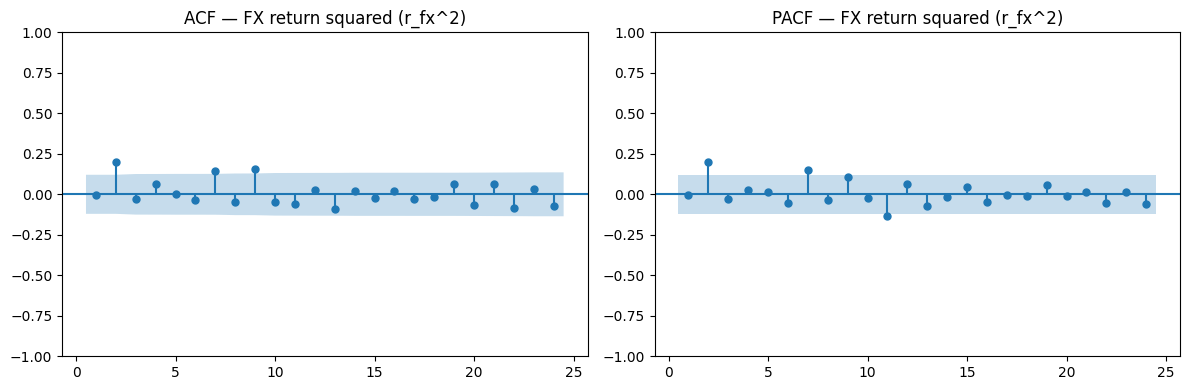

In [26]:
# Squared returns (volatility clustering proxy)
r_us_sq = df["r_us"] ** 2
r_fx_sq = df["r_fx"] ** 2

acf_pacf_panel(r_us_sq, "US equity return squared (r_us^2)", lags=24)
acf_pacf_panel(r_fx_sq, "FX return squared (r_fx^2)", lags=24)

### Additional volatility proxy: absolute returns

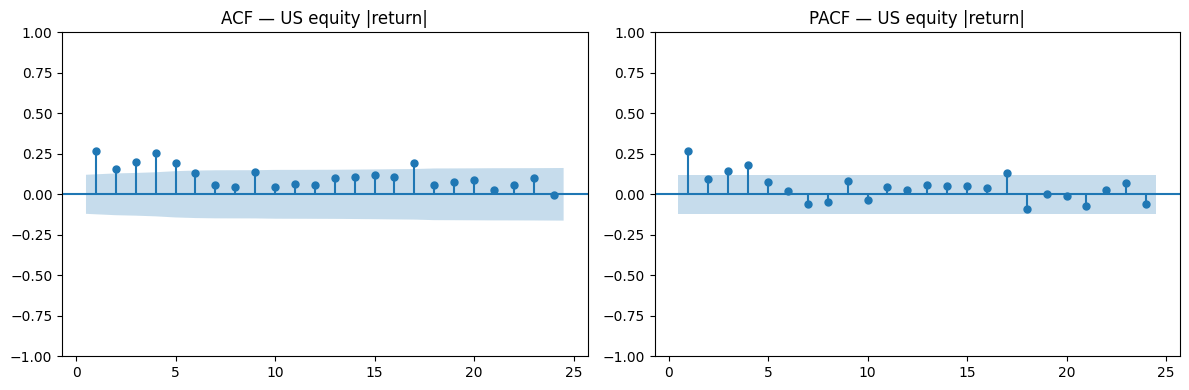

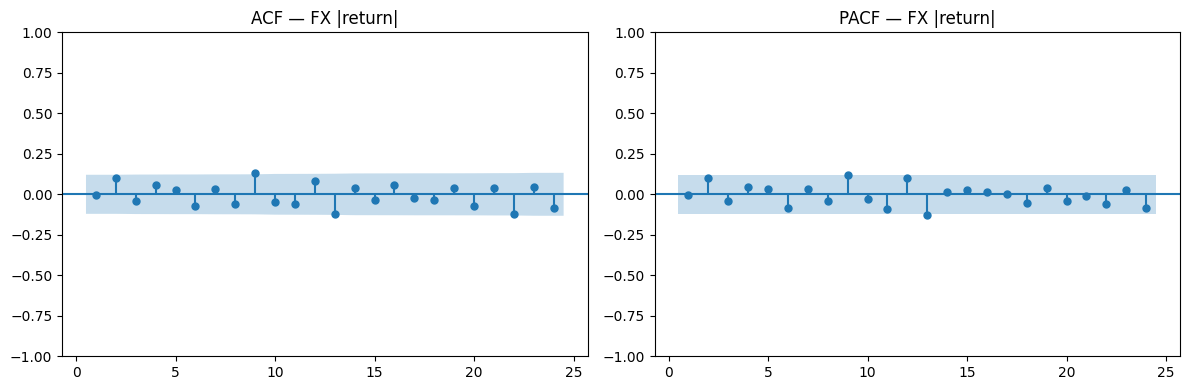

In [27]:
acf_pacf_panel(df["r_us"].abs(), "US equity |return|", lags=24)
acf_pacf_panel(df["r_fx"].abs(), "FX |return|", lags=24)

In [28]:
# Ljung–Box on absolute returns (volatility persistence check)

lb_rows_abs = []
for name, s in {"|r_us|": df["r_us"].abs(), "|r_fx|": df["r_fx"].abs()}.items():
    res = acorr_ljungbox(s.dropna(), lags=[12, 24], return_df=True)
    tmp = res.copy()
    tmp["variable"] = name
    tmp["lag"] = tmp.index
    lb_rows_abs.append(tmp[["variable", "lag", "lb_stat", "lb_pvalue"]])

lb_abs = pd.concat(lb_rows_abs, ignore_index=True)

p_abs = lb_abs.pivot(index="variable", columns="lag", values="lb_pvalue")
p_abs = p_abs.rename(columns={12: "pvalue (12)", 24: "pvalue (24)"})

dec_abs = (p_abs < alpha).replace({True: "Reject H0", False: "Fail to reject"})
dec_abs = dec_abs.rename(columns={"pvalue (12)": "decision (12)", "pvalue (24)": "decision (24)"})

out_abs = pd.concat([p_abs, dec_abs], axis=1)

out_abs_fmt = out_abs.copy()
out_abs_fmt["pvalue (12)"] = out_abs_fmt["pvalue (12)"].apply(fmt_p)
out_abs_fmt["pvalue (24)"] = out_abs_fmt["pvalue (24)"].apply(fmt_p)

display(out_abs_fmt)

print(f"Decision rule: reject H0 if p-value < {alpha}")

lag,pvalue (12),pvalue (24),decision (12),decision (24)
variable,,,,
|r_fx|,0.2311,0.1497,Fail to reject,Fail to reject
|r_us|,< 0.0001,< 0.0001,Reject H0,Reject H0


Decision rule: reject H0 if p-value < 0.05


## Q2.6 - Ljung–Box on squared returns (volatility clustering test)

In [29]:
# Ljung–Box on squared returns (volatility clustering check)

lb_rows_sq = []

for name, s in {"r_us^2": df["r_us"]**2, "r_fx^2": df["r_fx"]**2}.items():
    res = acorr_ljungbox(s.dropna(), lags=[12, 24], return_df=True)
    tmp = res.copy()
    tmp["variable"] = name
    tmp["lag"] = tmp.index
    lb_rows_sq.append(tmp[["variable", "lag", "lb_stat", "lb_pvalue"]])

lb2 = pd.concat(lb_rows_sq, ignore_index=True)

pvals2 = lb2.pivot(index="variable", columns="lag", values="lb_pvalue")
pvals2 = pvals2.rename(columns={12: "pvalue (12)", 24: "pvalue (24)"})

dec2 = (pvals2 < alpha).replace({True: "Reject H0", False: "Fail to reject"})
dec2 = dec2.rename(columns={"pvalue (12)": "decision (12)", "pvalue (24)": "decision (24)"})

out2 = pd.concat([pvals2, dec2], axis=1)

out2_fmt = out2.copy()
out2_fmt["pvalue (12)"] = out2_fmt["pvalue (12)"].apply(fmt_p)
out2_fmt["pvalue (24)"] = out2_fmt["pvalue (24)"].apply(fmt_p)

display(out2_fmt)
print(f"Decision rule: reject H0 if p-value < {alpha}")

lag,pvalue (12),pvalue (24),decision (12),decision (24)
variable,,,,
r_fx^2,0.0068,0.0371,Reject H0,Reject H0
r_us^2,< 0.0001,< 0.0001,Reject H0,Reject H0


Decision rule: reject H0 if p-value < 0.05


The Ljung–Box test applied to squared returns strongly rejects the null of no autocorrelation, especially for US equity returns. This provides clear evidence of volatility clustering, a well-known stylised fact in financial returns.

# Q3 - Time-series specification & parameter estimation (US variables)

In [30]:
# ============================================================
# Q3 — Full code (clean + bonus optimisations)
# ============================================================

# -------------------------
# Imports + display settings
# -------------------------
import numpy as np
import pandas as pd
import statsmodels.api as sm

from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.stats.diagnostic import acorr_ljungbox, het_arch
from statsmodels.stats.stattools import jarque_bera

import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

import warnings
warnings.filterwarnings("ignore", message="No frequency information was provided")
warnings.filterwarnings("ignore", category=UserWarning)

pd.set_option("display.float_format", lambda x: f"{x:,.4f}")

### Monthly alignment (month-end)

All series are first aligned onto a **monthly month-end (ME)** time index. This step is important because the ARIMA framework, as well as stationarity tests (ADF/KPSS) and diagnostic tools (ACF/PACF, Ljung–Box, ARCH tests), implicitly assume that observations are **equally spaced in time**.

In practice, we reindex each variable on a complete month-end grid ranging from the first to the last available observation. Any missing months are made explicit (as `NaN`). This avoids accidental irregular spacing in the data and ensures that all series are analyzed on a consistent and comparable temporal basis.

In [31]:
# -------------------------
# Helper: force monthly ME grid
# -------------------------
def ensure_monthly_me(s: pd.Series) -> pd.Series:
    """
    Force a complete monthly month-end index (ME) and sets freq metadata.
    """
    x = s.dropna().copy()
    x.index = pd.to_datetime(x.index)

    full_idx = pd.date_range(start=x.index.min(), end=x.index.max(), freq="ME")
    x = x.reindex(full_idx).asfreq("ME")

    x.index.name = "date"
    return x

### Constructing the working dataset (monthly ME) and first differences

We define the five core US time series used in Question 3:

- **Returns**: $r_{us}$ and $r_{fx}$, which are typically expected to behave as stationary processes (often close to $I(0)$).
- **Yields / term-structure variables**: $y^{S}_{us}$ (short yield), $y^{L}_{us}$ (long yield), and $ts_{us}$ (term spread), which empirically often behave like highly persistent or $I(1)$ series in levels.

After aligning every series on the same month-end grid, we construct **first differences** for the yield/spread variables:
$$
\Delta y_t = y_t - y_{t-1}.
$$
This is the natural stationary candidate when levels look $I(1)$. We later confirm this using ADF/KPSS tests and then choose an ARIMA specification consistent with the integration order (returns typically $d=0$; yields/spreads often $d=1$).

In [32]:
# -------------------------
# Build base series (monthly ME)
# -------------------------
us_raw = {
    "r_us": df["r_us"],
    "r_fx": df["r_fx"],
    "us_short_yield": df["us_short_yield"],
    "us_long_yield": df["us_long_yield"],
    "ts_us": df["ts_us"],
}

us = {k: ensure_monthly_me(v) for k, v in us_raw.items()}

# First differences for I(1) candidates
d_us_short = us["us_short_yield"].diff()
d_us_long  = us["us_long_yield"].diff()
d_ts_us    = us["ts_us"].diff()

### Stationarity assessment: ADF and KPSS (levels vs. differences)

Before fitting ARIMA models, we establish the **order of integration** of each series. This matters because ARIMA modelling depends critically on whether the series is stationary in levels ($I(0)$) or needs differencing ($I(1)$).

We use two complementary unit-root/stationarity tests:

- **ADF test (Augmented Dickey–Fuller)**  
  - Null hypothesis: $H_0$: the series has a **unit root** (non-stationary).  
  - Interpretation: small p-values (e.g. $p<0.05$) suggest rejecting the unit root and concluding $I(0)$.

- **KPSS test (Kwiatkowski–Phillips–Schmidt–Shin)**  
  - Null hypothesis: $H_0$: the series is **stationary**.  
  - Interpretation: small p-values suggest rejecting stationarity (evidence for non-stationarity).

Using both tests together is useful because they “pull” in opposite directions. In practice:

- A series is strongly consistent with $I(0)$ if **ADF rejects** the unit root and **KPSS does not reject** stationarity.
- A series is strongly consistent with $I(1)$ if **ADF does not reject** the unit root in levels while **KPSS rejects** stationarity, but **both tests support stationarity after first differencing**.

We therefore run ADF/KPSS on:
- **Levels**: $y_t$ for yields/spreads and $r_t$ for returns  
- **Differences**: $\Delta y_t = y_t - y_{t-1}$ for yield/spread candidates

This step determines whether we estimate:
- an ARMA/ARIMA with $d=0$ for stationary series (typically returns),
- an ARIMA with $d=1$ for series that become stationary after differencing (typically yields/spreads).

In [33]:
# -------------------------
# Stationarity tables (ADF + KPSS)
# -------------------------
def stationarity_table(series_dict, adf_autolag="AIC", kpss_reg="c"):
    rows = []
    for name, s in series_dict.items():
        x = s.dropna()

        # ADF: H0 = unit root
        adf_stat, adf_p, _, _, _, _ = adfuller(x, autolag=adf_autolag)

        # KPSS: H0 = stationary
        try:
            kpss_stat, kpss_p, _, _ = kpss(x, regression=kpss_reg, nlags="auto")
        except Exception:
            kpss_stat, kpss_p = np.nan, np.nan

        rows.append({
            "series": name,
            "ADF stat": adf_stat,
            "ADF p": adf_p,
            "KPSS stat": kpss_stat,
            "KPSS p": kpss_p,
            "ADF says I(0)@5%": (adf_p < 0.05),
            "KPSS says I(0)@5%": (kpss_p >= 0.05) if not np.isnan(kpss_p) else np.nan,
        })

    return pd.DataFrame(rows).set_index("series")

levels_check = {
    "us_short_yield (level)": us["us_short_yield"],
    "us_long_yield (level)":  us["us_long_yield"],
    "ts_us (level)":          us["ts_us"],
    "r_us (return)":          us["r_us"],
    "r_fx (return)":          us["r_fx"],
}

diffs_check = {
    "Δ us_short_yield": d_us_short,
    "Δ us_long_yield":  d_us_long,
    "Δ ts_us":          d_ts_us,
}

display(stationarity_table(levels_check).round(4))
display(stationarity_table(diffs_check).round(4))

,ADF stat,ADF p,KPSS stat,KPSS p,ADF says I(0)@5%,KPSS says I(0)@5%
series,,,,,,
us_short_yield (level),-2.7239,0.0700,0.4280,0.0651,False,True
us_long_yield (level),-1.7536,0.4037,0.6854,0.0149,False,False
ts_us (level),-2.0455,0.2670,0.9474,0.0100,False,False
r_us (return),-6.7786,0.0000,0.2314,0.1000,True,True
r_fx (return),-10.1115,0.0000,0.0467,0.1000,True,True


,ADF stat,ADF p,KPSS stat,KPSS p,ADF says I(0)@5%,KPSS says I(0)@5%
series,,,,,,
Δ us_short_yield,-4.9658,0.0000,0.1063,0.1000,True,True
Δ us_long_yield,-15.0274,0.0000,0.1576,0.1000,True,True
Δ ts_us,-14.9720,0.0000,0.0776,0.1000,True,True


### Interpretation of stationarity test results

The ADF and KPSS outcomes give a fairly clean—and economically intuitive—classification of the series.

**Returns ($r_{us}$, $r_{fx}$).**  
Both the US equity return series and the FX return series strongly reject the unit-root null in the ADF test (p-values essentially zero), while KPSS does not reject stationarity. Taken together, this is consistent with **stationarity in levels**, i.e. $I(0)$. This matches the usual empirical finance view: returns fluctuate around a (roughly) constant mean rather than exhibiting a persistent stochastic trend.

**Yields and term spread in levels.**  
For the short yield, ADF does not reject a unit root at the 5% level, while KPSS is borderline and does not clearly reject stationarity. This is “mixed” evidence: the series looks highly persistent, and it is safer to avoid treating it as $I(0)$ without qualification.  
For the long yield and the term spread, the evidence is more decisive: ADF fails to reject a unit root in levels, while KPSS rejects stationarity. This combination is strongly consistent with **non-stationarity in levels**, i.e. an $I(1)$-type behaviour.

**First differences of yields and spreads.**  
After differencing, all yield-related variables strongly reject the unit root under ADF, and KPSS no longer rejects stationarity. Hence $\Delta y_t$ is stationary for these series:
$$
\Delta y_t = y_t - y_{t-1}.
$$
This is the textbook pattern for $I(1)$ variables: non-stationary in levels, stationary in first differences.

**Implications for modelling.**  
These tests pin down the ARIMA differencing order:
- Returns ($r_{us}$, $r_{fx}$): ARIMA models with $d=0$ (ARMA-type mean dynamics).
- Yields and term-structure variables: ARIMA models with $d=1$, with an explicit check for a drift term (i.e. constant in the differenced equation) in the subsequent specification step.

This stationarity step provides the statistical basis for the time-series specifications estimated next.

### Trend versus no-trend unit root tests on yield levels

Before specifying the ARIMA models, we further investigate whether the non-stationarity of the yield variables is driven by a deterministic trend or by a stochastic trend. This distinction matters because, in the presence of a deterministic trend, including a trend or a drift term in the model may be appropriate.

We therefore re-run the unit root tests on the level series using two alternative specifications:
- a constant only ($c$),
- a constant plus linear trend ($ct$).

For each yield series, we report ADF and KPSS p-values under both specifications. The ADF test evaluates the null hypothesis of a unit root, while the KPSS test evaluates the null hypothesis of stationarity around the specified deterministic component.

This complementary exercise allows us to assess whether the apparent non-stationarity of yields could be attributed to a deterministic trend rather than to a unit root. The results guide our subsequent choice of differencing order and inform whether a drift term should be considered in the ARIMA specifications for \(d=1\) models.

In [34]:
# -------------------------
# Trend vs no-trend checks on levels (single cell, no duplicate)
# -------------------------
def stationarity_adf_kpss(s, name):
    x = s.dropna()
    out = []
    for reg in ["c", "ct"]:  # constant ; constant + trend
        adf_stat, adf_p, _, _, _, _ = adfuller(x, regression=reg, autolag="AIC")
        try:
            kpss_stat, kpss_p, _, _ = kpss(x, regression=reg, nlags="auto")
        except Exception:
            kpss_stat, kpss_p = np.nan, np.nan
        out.append({"reg": reg, "ADF p": adf_p, "KPSS p": kpss_p})
    return pd.DataFrame(out).assign(series=name)

tests_levels = pd.concat([
    stationarity_adf_kpss(us["us_short_yield"], "us_short_yield"),
    stationarity_adf_kpss(us["us_long_yield"], "us_long_yield"),
    stationarity_adf_kpss(us["ts_us"], "ts_us"),
], ignore_index=True)

display(tests_levels)

,reg,ADF p,KPSS p,series
0,c,0.0700,0.0651,us_short_yield
1,ct,0.2063,0.0100,us_short_yield
2,c,0.4037,0.0149,us_long_yield
3,ct,0.8269,0.0100,us_long_yield
4,c,0.2670,0.0100,ts_us
5,ct,0.5475,0.0100,ts_us


### Interpretation of the trend vs. no-trend stationarity checks (yield levels)

This table reports ADF and KPSS p-values on the **level** series under two deterministic specifications: a constant only ($c$) and a constant plus linear trend ($ct$). The goal is to check whether yields could be *trend-stationary* (stationary around a deterministic trend) rather than truly $I(1)$.

- **Short yield level ($us\_short\_yield$).**  
  With a constant only ($c$), the ADF p-value is $0.070$: we **do not reject** a unit root at 5% (borderline). KPSS gives $p=0.065$, so we **do not reject** stationarity around a constant. This is a classic “high persistence / borderline” case.  
  With a trend ($ct$), ADF p-value rises to $0.206$ (even less evidence against a unit root) while KPSS p-value drops to $0.010$, meaning KPSS **rejects** trend-stationarity. Overall, the tests do **not** support trend-stationary behaviour, so treating the series as $I(1)$ is the safer choice.

- **Long yield level ($us\_long\_yield$).**  
  Under $c$, ADF p-value is $0.404$ (unit root not rejected) while KPSS p-value is $0.0149$ (stationarity rejected). Under $ct$, ADF is even larger ($0.827$) and KPSS still rejects ($0.010$).  
  This pattern is consistent with a **stochastic trend** (unit root), not a deterministic trend: we therefore model the series as $I(1)$ and difference it.

- **Term spread level ($ts\_{us}$).**  
  Under both $c$ and $ct$, ADF does not reject the unit root (p-values $0.267$ and $0.548$), while KPSS rejects stationarity (p-value $0.010$ in both cases).  
  This is strong evidence in favour of an **$I(1)$** specification rather than trend-stationarity.

**Bottom line.** Across yields and the term spread, the evidence does **not** support trend-stationary dynamics. We therefore proceed with **ARIMA($p,1,q$)** specifications for these variables (and we later test explicitly whether a *drift* term in the differenced equation is warranted, rather than imposing a deterministic trend by default).

### ACF/PACF diagnostics (model identification)

Before choosing a final ARIMA specification, we inspect the **sample autocorrelation function (ACF)** and the **partial autocorrelation function (PACF)** as a quick diagnostic for short-run dependence in each series.

- **Returns ($r_{us}$, $r_{fx}$).**  
  Since both return series are classified as $I(0)$, we examine ACF/PACF in **levels**. The plots are mainly used to assess whether the conditional mean contains any meaningful ARMA-type structure (a few significant spikes) or whether returns behave close to **white noise** (most correlations near zero).

- **Yields / term-structure variables ($us\_short\_yield$, $us\_long\_yield$, $ts_{us}$).**  
  Because these series behave like $I(1)$ in levels, we look at the ACF/PACF of **first differences**:
  $$
  \Delta y_t = y_t - y_{t-1},
  $$
  which should be approximately stationary if the level series is integrated. The ACF/PACF of $\Delta y_t$ provide intuition for plausible **low-order ARMA dynamics** in differences, i.e. ARIMA($p,1,q$).

Overall, we treat ACF/PACF as a **sanity check** and a guide for reasonable lag orders (e.g., whether dependence dies out quickly and whether a small number of lags might suffice). The final choice of $(p,q)$ is then made systematically using a **BIC-based grid search**, to keep model selection consistent across series.

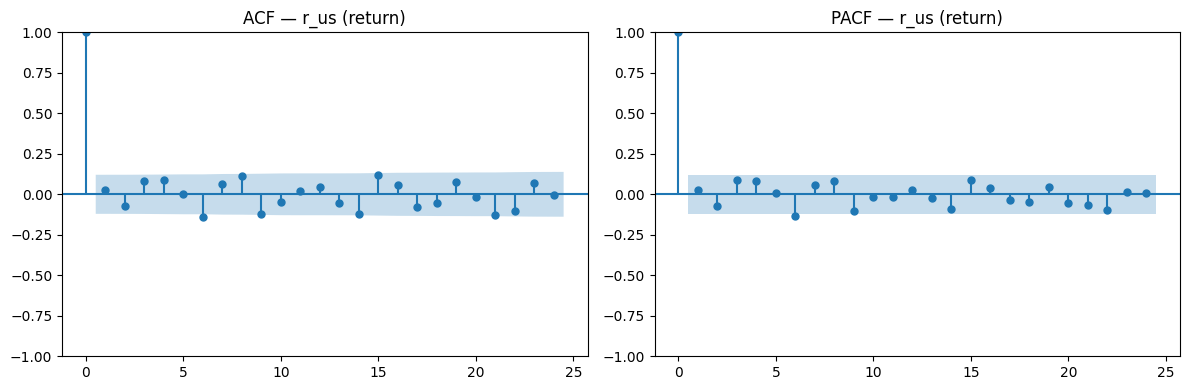

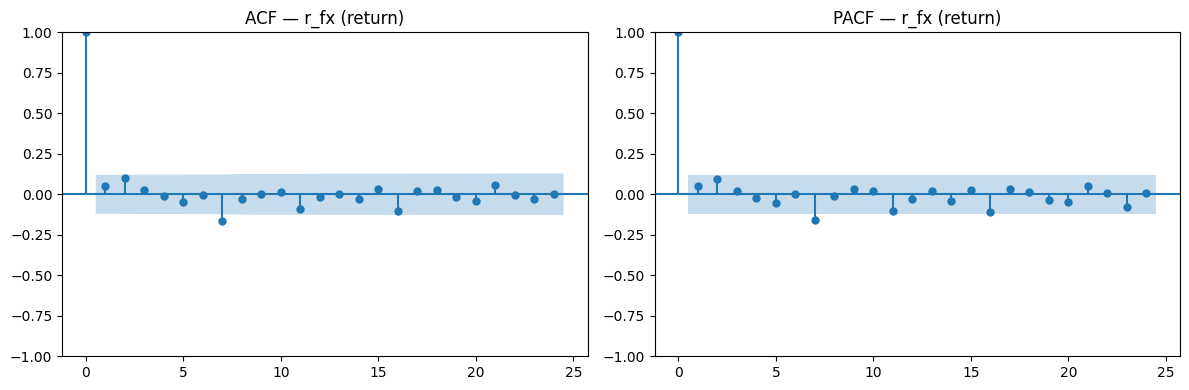

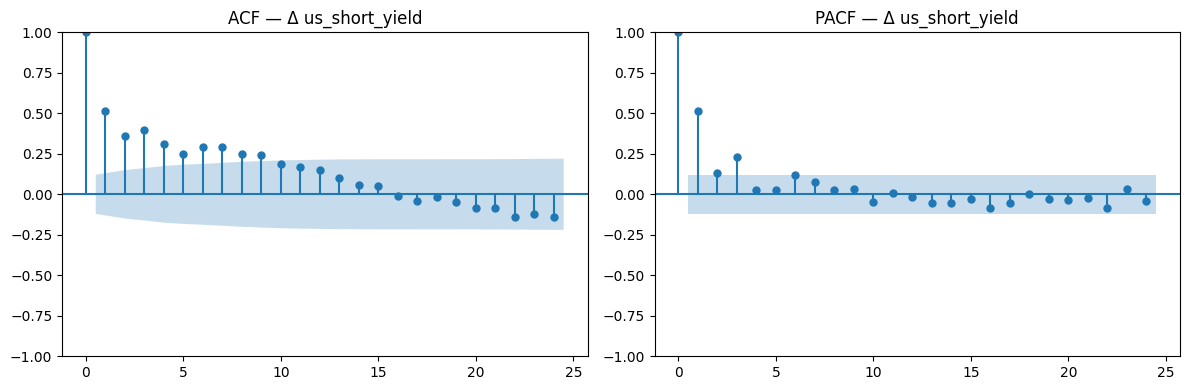

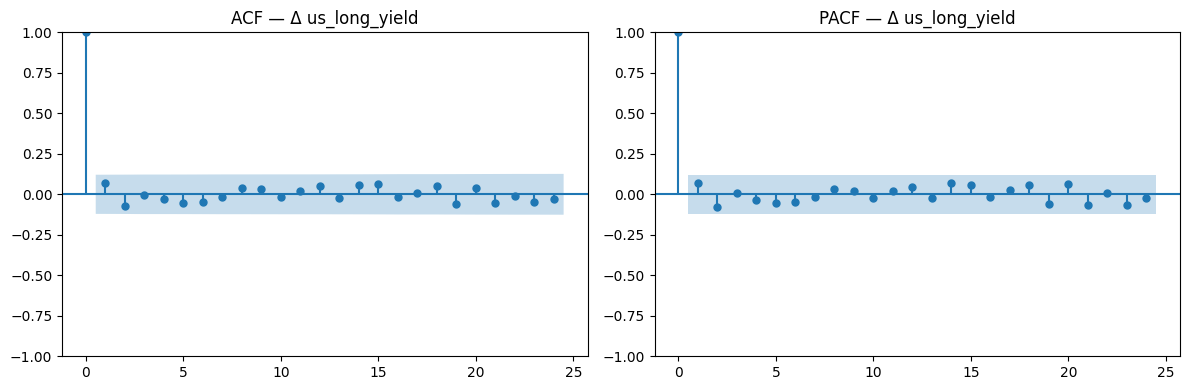

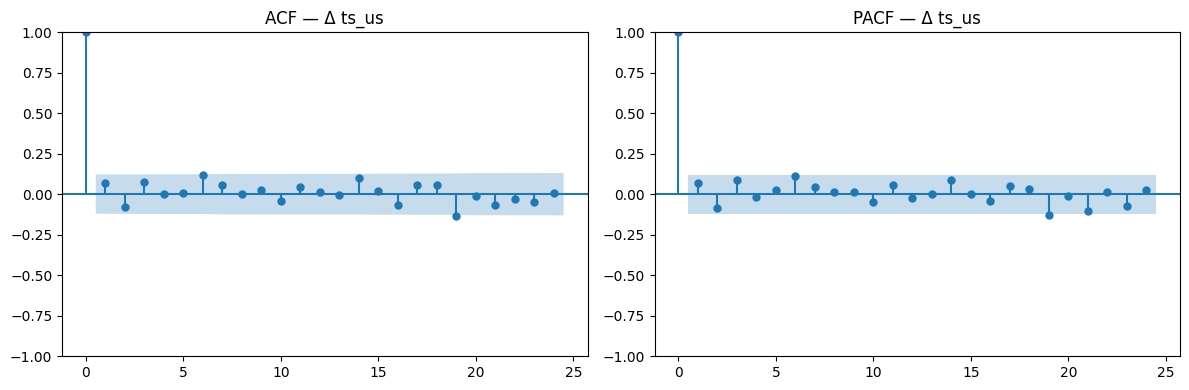

In [35]:
# -------------------------
# ACF/PACF plots
# -------------------------
def acf_pacf_plots(s, title, lags=24):
    x = s.dropna()
    fig, ax = plt.subplots(1, 2, figsize=(12, 4))
    plot_acf(x, lags=lags, ax=ax[0])
    plot_pacf(x, lags=lags, ax=ax[1], method="ywm")
    ax[0].set_title(f"ACF — {title}")
    ax[1].set_title(f"PACF — {title}")
    plt.tight_layout()
    plt.show()

# Returns
acf_pacf_plots(us["r_us"], "r_us (return)")
acf_pacf_plots(us["r_fx"], "r_fx (return)")

# For I(1) series, inspect differences
acf_pacf_plots(d_us_short, "Δ us_short_yield")
acf_pacf_plots(d_us_long,  "Δ us_long_yield")
acf_pacf_plots(d_ts_us,    "Δ ts_us")

### Autocorrelation structure and preliminary model identification

We next examine the autocorrelation (ACF) and partial autocorrelation (PACF) functions of the stationary series in order to guide the specification of the ARMA dynamics.

#### Stock market returns ($r_{us}$)

The ACF and PACF of US stock returns display very weak serial dependence. Most autocorrelations lie within the 95% confidence bands, with no clear cutoff or persistent pattern. This suggests that returns are close to white noise in the mean, with at most weak short-run dependence. As a result, low-order ARMA models are appropriate, and parsimony is desirable. This is consistent with the common empirical finding that equity returns exhibit little predictability in the conditional mean.

#### Exchange rate returns ($r_{fx}$)

Similarly, the ACF and PACF of exchange rate returns show no strong or systematic autocorrelation structure. Aside from a few isolated spikes at short lags, all correlations remain small and statistically insignificant. This again points toward weak mean dynamics, justifying the use of simple ARMA specifications with a small number of MA terms.

#### First differences of short-term yields ($\Delta y^{short}_{us}$)

In contrast, the first difference of the short-term yield exhibits a clear serial correlation pattern. The ACF shows a slow decay over several lags, while the PACF displays significant spikes at the first few lags. This behavior is indicative of persistent short-run dynamics and is consistent with an ARMA-type structure in differences. These patterns motivate the use of an $ARIMA(p,1,q)$ specification for the level of short-term yields, allowing for rich short-run adjustment following shocks.

#### First differences of long-term yields ($\Delta y^{long}_{us}$)

For long-term yields, the ACF and PACF of the differenced series are much weaker. Most autocorrelations fall within the confidence bands, suggesting limited short-run dependence once the unit root is removed. This points toward a relatively simple $ARIMA(0,1,q)$ representation, where only modest moving-average dynamics are required to capture short-term fluctuations.

#### First differences of the term spread ($\Delta ts_{us}$)

The differenced term spread also shows little evidence of strong autocorrelation. Both the ACF and PACF remain close to zero at all lags, indicating that most of the persistence observed in levels is eliminated by first differencing. As with long-term yields, this supports a parsimonious $ARIMA(0,1,q)$ specification for the spread.

#### Summary

Overall, the ACF/PACF analysis confirms a sharp contrast between returns and interest rate levels. Returns exhibit weak mean dynamics, consistent with efficient markets, while interest rate variables display strong persistence in levels and meaningful short-run dynamics in first differences. These findings provide a clear empirical motivation for modeling returns as ARMA processes and yields as ARIMA processes with one order of integration.

### Model selection via information criteria (ARIMA grid search)

To identify an appropriate time-series specification for each variable, we run a systematic grid search over ARIMA$(p,d,q)$ models. For each candidate series, we fix the integration order $d$ based on the stationarity results (returns: $d=0$; yields/spread in levels: $d=1$) and then explore low-order combinations of $(p,q)$ up to a small maximum (here $p,q \le 4$). 

For each candidate model, we estimate the parameters using a SARIMAX/ARIMA likelihood framework and compute standard information criteria:
$$
\text{AIC} = -2\ell(\hat{\theta}) + 2k, 
\qquad
\text{BIC} = -2\ell(\hat{\theta}) + k\ln(T),
$$
where $\ell(\hat{\theta})$ is the maximized log-likelihood, $k$ is the number of estimated parameters, and $T$ is the sample size. 

Our baseline selection criterion is the **BIC**, since it penalizes model complexity more strongly than AIC and typically yields more parsimonious specifications in finite samples—particularly relevant here given that returns often exhibit weak mean dynamics.

Finally, we allow for different deterministic components through the `trend` argument:
- `trend='n'`: no deterministic term,
- `trend='c'`: constant term (and, when $d=1$, this corresponds to a **drift** term in the level representation).

We retain the specification with the lowest BIC across all candidates and proceed to diagnostic checking to validate that the selected model adequately captures the remaining serial dependence.

In [36]:
# -------------------------
# IC grid + pick best ARIMA spec (BIC default)
# -------------------------
def ic_grid_arima(y: pd.Series, d: int, p_max=4, q_max=4, trend="c", criterion="BIC"):
    y = y.dropna()
    out = []

    for p in range(p_max + 1):
        for q in range(q_max + 1):
            if p == 0 and q == 0:
                continue
            try:
                res = sm.tsa.SARIMAX(
                    y, order=(p, d, q),
                    trend=trend,
                    enforce_stationarity=False,
                    enforce_invertibility=False
                ).fit(disp=False)
                out.append({"p": p, "d": d, "q": q, "trend": trend, "AIC": res.aic, "BIC": res.bic})
            except Exception:
                pass

    tab = pd.DataFrame(out).sort_values(criterion).reset_index(drop=True)
    return tab

def pick_best_model_spec(y: pd.Series, d: int, p_max=4, q_max=4, criterion="BIC"):
    tabs = []
    for tr in ["n", "c"]:  # no constant vs constant (for d=1, 'c' behaves like drift)
        tab = ic_grid_arima(y, d=d, p_max=p_max, q_max=q_max, trend=tr, criterion=criterion)
        tabs.append(tab)

    all_tab = pd.concat(tabs, ignore_index=True).sort_values(criterion).reset_index(drop=True)
    best_row = all_tab.iloc[0]
    best = {"p": int(best_row["p"]), "d": int(best_row["d"]), "q": int(best_row["q"]), "trend": best_row["trend"]}
    return all_tab, best

### Estimation of the selected ARIMA model and residual diagnostics

After selecting the preferred ARIMA$(p,d,q)$ specification using the Bayesian Information Criterion (BIC), we estimate the model by maximum likelihood. In general form, an ARIMA model can be written as
$$
(1 - L)^d y_t = \mu + \text{AR terms} + \text{MA terms} + \varepsilon_t,
$$
where $L$ denotes the lag operator and $\varepsilon_t$ is an innovation with zero mean and constant variance. When $d = 1$, the inclusion of a constant term corresponds to a **drift** in the level of the series.

We then report the **key parameter estimates**, namely the AR and MA coefficients (and, when applicable, the intercept or drift), together with **robust standard errors**, $t$-statistics, and $p$-values. Robust standard errors are used because financial time series often deviate from the homoskedastic Gaussian assumptions underlying classical inference.

To assess whether the selected specification adequately captures the dynamics of the data, we perform a standard set of residual diagnostics based on the fitted residuals $\hat{\varepsilon}_t$.

- **Ljung–Box test on residuals**  
  This test examines whether there is remaining serial correlation in the residuals:
  $$
  H_0:\ \text{no autocorrelation up to lag } h.
  $$
  We focus on lags 12 and 24, corresponding to one and two years for monthly data. Large $p$-values indicate that the mean dynamics have been successfully captured by the model.

- **Ljung–Box test on squared residuals**  
  Applied to $\hat{\varepsilon}_t^2$, this test provides a quick check for volatility clustering. Rejection suggests the presence of time-varying conditional variance.

- **ARCH LM test**  
  This test directly evaluates conditional heteroskedasticity:
  $$
  H_0:\ \text{no ARCH effects up to lag } m.
  $$
  Rejection implies that, although the ARIMA model may be adequate for the conditional mean, a volatility model such as GARCH could be more appropriate for the conditional variance.

- **Jarque–Bera test (optional)**  
  This test assesses the normality of residuals. In financial applications, rejection is common and typically reflects excess kurtosis or skewness. We therefore interpret this result as supplementary evidence rather than a strict model rejection criterion.

Overall, these diagnostics ensure that model selection is not only driven by information criteria, but is also supported by residual behaviour consistent with a well-specified conditional mean.

In [37]:
# -------------------------
# Fit best ARIMA + diagnostics
# -------------------------
def fit_best_arima(y: pd.Series, name: str, d: int, p_max=4, q_max=4, criterion="BIC", lb_lags=(12,24)):
    y = y.dropna()

    tab, best = pick_best_model_spec(y, d=d, p_max=p_max, q_max=q_max, criterion=criterion)
    p_best, d_best, q_best, trend_best = best["p"], best["d"], best["q"], best["trend"]

    res = sm.tsa.SARIMAX(
        y, order=(p_best, d_best, q_best),
        trend=trend_best,
        enforce_stationarity=False,
        enforce_invertibility=False
    ).fit(disp=False, cov_type="robust")

    resid = res.resid.dropna()

    params = pd.DataFrame({
        "coef": res.params,
        "se(robust)": res.bse,
        "t": res.tvalues,
        "p": res.pvalues,
    }).round(4)

    lb = acorr_ljungbox(resid, lags=list(lb_lags), return_df=True)[["lb_stat","lb_pvalue"]].round(4)
    lb2 = acorr_ljungbox(resid**2, lags=list(lb_lags), return_df=True)[["lb_stat","lb_pvalue"]].round(4)

    arch_lm = het_arch(resid, nlags=12)
    arch_row = pd.Series({"ARCH LM stat": arch_lm[0], "ARCH LM pval": arch_lm[1]}).round(4)

    jb_stat, jb_p, _, _ = jarque_bera(resid)
    jb_row = pd.Series({"JB stat": jb_stat, "JB pval": jb_p}).round(4)

    print(f"\n=== {name} | best ARIMA({p_best},{d_best},{q_best}), trend='{trend_best}' by {criterion} ===")
    display(tab.head(10).round(3))

    print("Key parameters:")
    display(params)

    print("Residual Ljung–Box (want p-values > 0.05):")
    display(lb)

    print("Ljung–Box on squared residuals (volatility clustering check):")
    display(lb2)

    print("ARCH LM (p < 0.05 suggests heteroskedasticity):")
    display(arch_row)

    print("Jarque–Bera (normality, optional):")
    display(jb_row)

    return res, (p_best, d_best, q_best, trend_best), tab

### Model estimation strategy

Based on the stationarity analysis and the ACF/PACF evidence, we estimate separate ARIMA models for each series, allowing for different orders of integration.

For the **return series** (stock market returns and exchange rate returns), both ADF and KPSS tests indicate stationarity in levels. Consequently, we model these series directly using $ARIMA(p,0,q)$ specifications.

For the **interest rate variables** (short-term yield, long-term yield, and the term spread), the level series exhibit unit root behaviour, while their first differences are stationary. These variables are therefore modelled as integrated processes using $ARIMA(p,1,q)$ specifications.

For each series, the autoregressive and moving average orders $(p,q)$, as well as the inclusion of a constant term, are selected using the **Bayesian Information Criterion (BIC)**. We allow for both specifications with and without a constant; when $d = 1$, a constant corresponds to a drift term in the level of the process.

This approach ensures a consistent modelling strategy across series while allowing for heterogeneity in their dynamic properties.

In [38]:
# -------------------------
# Fit models
# -------------------------
models = {}
orders = {}
ic_tables = {}

# Returns: ARIMA(p,0,q)
for key in ["r_us", "r_fx"]:
    res, order, tab = fit_best_arima(us[key], key, d=0, criterion="BIC")
    models[key], orders[key], ic_tables[key] = res, order, tab

# I(1) levels: ARIMA(p,1,q)
for key in ["us_short_yield", "us_long_yield", "ts_us"]:
    res, order, tab = fit_best_arima(us[key], key, d=1, criterion="BIC")
    models[key], orders[key], ic_tables[key] = res, order, tab


=== r_us | best ARIMA(0,0,4), trend='n' by BIC ===


,p,d,q,trend,AIC,BIC
0,0,0,4,n,"1,496.9770","1,514.7610"
1,0,0,4,c,"1,493.7640","1,515.1050"
2,0,0,3,c,"1,497.4110","1,515.2140"
3,0,0,3,n,"1,501.3660","1,515.6090"
4,0,0,2,c,"1,502.5110","1,516.7690"
5,2,0,4,c,"1,488.3290","1,516.7840"
6,2,0,3,c,"1,492.0990","1,517.0230"
7,2,0,2,c,"1,495.6410","1,517.0280"
8,2,0,4,n,"1,492.5040","1,517.4020"
9,0,0,1,c,"1,506.8440","1,517.5490"


Key parameters:


,coef,se(robust),t,p
ma.L1,0.0455,0.0876,0.5197,0.6033
ma.L2,-0.0374,0.0713,-0.5247,0.5998
ma.L3,0.1162,0.0711,1.6344,0.1022
ma.L4,0.0702,0.0773,0.9087,0.3635
sigma2,18.2307,1.9611,9.2962,0.0000


Residual Ljung–Box (want p-values > 0.05):


,lb_stat,lb_pvalue
12,12.0589,0.4410
24,30.2974,0.1751


Ljung–Box on squared residuals (volatility clustering check):


,lb_stat,lb_pvalue
12,56.7691,0.0000
24,68.7347,0.0000


ARCH LM (p < 0.05 suggests heteroskedasticity):


ARCH LM stat   36.0016
ARCH LM pval    0.0003
dtype: float64

Jarque–Bera (normality, optional):


JB stat   40.6754
JB pval    0.0000
dtype: float64


=== r_fx | best ARIMA(0,0,3), trend='n' by BIC ===


,p,d,q,trend,AIC,BIC
0,0,0,3,n,"1,215.1180","1,229.3610"
1,0,0,4,n,"1,211.9340","1,229.7180"
2,0,0,2,n,"1,219.2950","1,229.9890"
3,0,0,1,n,"1,224.4260","1,231.5630"
4,1,0,3,n,"1,216.1440","1,233.9470"
5,2,0,0,n,"1,223.8000","1,234.5050"
6,0,0,3,c,"1,216.7990","1,234.6020"
7,0,0,4,c,"1,213.5160","1,234.8570"
8,1,0,2,n,"1,220.6230","1,234.8810"
9,0,0,2,c,"1,220.8330","1,235.0910"


Key parameters:


,coef,se(robust),t,p
ma.L1,0.0484,0.0568,0.8515,0.3945
ma.L2,0.1137,0.0753,1.5098,0.1311
ma.L3,0.0363,0.0593,0.6118,0.5407
sigma2,6.0785,0.6995,8.6903,0.0000


Residual Ljung–Box (want p-values > 0.05):


,lb_stat,lb_pvalue
12,10.6176,0.5619
24,17.3451,0.8336


Ljung–Box on squared residuals (volatility clustering check):


,lb_stat,lb_pvalue
12,20.1264,0.0647
24,29.3425,0.2075


ARCH LM (p < 0.05 suggests heteroskedasticity):


ARCH LM stat   17.8364
ARCH LM pval    0.1208
dtype: float64

Jarque–Bera (normality, optional):


JB stat   23.7701
JB pval    0.0000
dtype: float64


=== us_short_yield | best ARIMA(1,1,1), trend='n' by BIC ===


,p,d,q,trend,AIC,BIC
0,1,1,1,n,-234.7940,-224.1000
1,3,1,0,n,-236.1980,-221.9550
2,1,1,2,n,-235.9750,-221.7330
3,2,1,1,n,-235.9540,-221.6960
4,1,1,1,c,-232.8250,-218.5670
5,2,1,2,n,-235.9420,-218.1380
6,1,1,0,n,-225.0390,-217.9030
7,3,1,1,n,-234.7870,-216.9840
8,1,1,3,n,-234.4720,-216.6880
9,3,1,0,c,-234.2740,-216.4710


Key parameters:


,coef,se(robust),t,p
ar.L1,0.8770,0.0793,11.0649,0.0000
ma.L1,-0.5569,0.1295,-4.2988,0.0000
sigma2,0.0233,0.0066,3.5505,0.0004


Residual Ljung–Box (want p-values > 0.05):


,lb_stat,lb_pvalue
12,8.3208,0.7596
24,13.0304,0.9656


Ljung–Box on squared residuals (volatility clustering check):


,lb_stat,lb_pvalue
12,12.3134,0.4209
24,13.8442,0.9501


ARCH LM (p < 0.05 suggests heteroskedasticity):


ARCH LM stat   10.2469
ARCH LM pval    0.5943
dtype: float64

Jarque–Bera (normality, optional):


JB stat   3,308.4644
JB pval       0.0000
dtype: float64


=== us_long_yield | best ARIMA(0,1,2), trend='n' by BIC ===


,p,d,q,trend,AIC,BIC
0,0,1,2,n,10.7880,21.4700
1,1,1,0,n,16.0750,23.2110
2,0,1,1,n,16.6010,23.7300
3,1,1,2,n,12.6220,26.8650
4,0,1,2,c,12.7800,27.0220
5,3,1,0,n,12.8130,27.0560
6,2,1,0,n,17.2330,27.9270
7,0,1,3,n,13.7120,27.9400
8,1,1,1,n,17.7550,28.4490
9,1,1,0,c,18.0720,28.7770


Key parameters:


,coef,se(robust),t,p
ma.L1,0.0799,0.0773,1.0338,0.3012
ma.L2,-0.0668,0.0686,-0.9744,0.3299
sigma2,0.0596,0.0066,9.0609,0.0000


Residual Ljung–Box (want p-values > 0.05):


,lb_stat,lb_pvalue
12,3.7816,0.9871
24,9.3213,0.9968


Ljung–Box on squared residuals (volatility clustering check):


,lb_stat,lb_pvalue
12,0.1504,1.0000
24,0.1790,1.0000


ARCH LM (p < 0.05 suggests heteroskedasticity):


ARCH LM stat   19.3655
ARCH LM pval    0.0801
dtype: float64

Jarque–Bera (normality, optional):


JB stat   53,093.8363
JB pval        0.0000
dtype: float64


=== ts_us | best ARIMA(0,1,2), trend='n' by BIC ===


,p,d,q,trend,AIC,BIC
0,0,1,2,n,54.0750,64.7570
1,1,1,0,n,59.2490,66.3860
2,0,1,1,n,59.5730,66.7020
3,3,1,0,n,54.4270,68.6700
4,0,1,2,c,55.5980,69.8410
5,1,1,2,n,55.6420,69.8850
6,0,1,3,n,55.9070,70.1340
7,1,1,1,n,59.4920,70.1860
8,2,1,0,n,60.0810,70.7740
9,1,1,0,c,60.9820,71.6870


Key parameters:


,coef,se(robust),t,p
ma.L1,0.0971,0.0688,1.4121,0.1579
ma.L2,-0.0811,0.0717,-1.1304,0.2583
sigma2,0.0704,0.0076,9.2497,0.0000


Residual Ljung–Box (want p-values > 0.05):


,lb_stat,lb_pvalue
12,5.9684,0.9177
24,17.8921,0.8082


Ljung–Box on squared residuals (volatility clustering check):


,lb_stat,lb_pvalue
12,0.4378,1.0000
24,0.5768,1.0000


ARCH LM (p < 0.05 suggests heteroskedasticity):


ARCH LM stat   25.2421
ARCH LM pval    0.0137
dtype: float64

Jarque–Bera (normality, optional):


JB stat   12,839.5632
JB pval        0.0000
dtype: float64

### Interpretation of the estimated ARIMA models

We now discuss the selected specifications and the main empirical findings for each series, focusing on the adequacy of the conditional mean dynamics and the behaviour of the residuals.

#### Stock market returns ($r_{us}$)

US equity returns are best described by an $ARIMA(0,0,4)$ model without a constant. The moving-average coefficients are individually not statistically significant at conventional levels, which is consistent with the well-documented weak predictability of asset returns.

Residual diagnostics confirm that the conditional mean is adequately specified: Ljung–Box tests at lags 12 and 24 fail to reject the null of no remaining serial correlation. However, both the Ljung–Box test on squared residuals and the ARCH LM test strongly reject the null, providing clear evidence of volatility clustering. In addition, the Jarque–Bera test rejects normality, indicating fat tails. Overall, this suggests that while ARIMA is sufficient for the conditional mean, a volatility model such as GARCH would be more appropriate for the conditional variance.

#### Exchange rate returns ($r_{fx}$)

Exchange rate returns are modelled as $ARIMA(0,0,3)$ without a constant. As for equity returns, the MA coefficients are not statistically significant, again pointing to weak linear predictability in the mean.

Residual diagnostics indicate no remaining serial correlation, with large Ljung–Box p-values at both horizons. Evidence of conditional heteroskedasticity is weaker than for equity returns: neither the ARCH LM test nor the Ljung–Box test on squared residuals strongly reject at the 5% level. Normality is rejected, which is common for financial returns. Overall, the ARIMA specification provides an adequate description of the mean dynamics.

#### Short-term interest rate ($y^{short}_{us}$)

The short-term yield is best captured by an $ARIMA(1,1,1)$ model without drift. Both the AR and MA coefficients are highly statistically significant, indicating strong persistence in changes of short-term rates.

Residual diagnostics are very satisfactory: Ljung–Box tests show no remaining serial correlation, and there is no evidence of conditional heteroskedasticity. The Jarque–Bera test rejects normality, but this is not unusual for interest rate changes and does not invalidate the specification. Overall, the $ARIMA(1,1,1)$ model provides a good representation of short-rate dynamics.

#### Long-term interest rate ($y^{long}_{us}$)

Long-term yields are modelled as $ARIMA(0,1,2)$ without drift. The MA coefficients are not individually significant, suggesting that changes in long-term rates are close to white noise.

Residual diagnostics are strong: there is no remaining autocorrelation, and no evidence of volatility clustering. As for other series, residual normality is rejected, but this is not central for mean dynamics. The results indicate that a parsimonious integrated MA specification is sufficient for long-term yields.

#### Term spread ($ts_{us}$)

The term spread is also best described by an $ARIMA(0,1,2)$ model without drift. The MA terms are not statistically significant, pointing to limited short-run predictability in changes of the spread.

Residuals show no remaining serial correlation. While the ARCH LM test rejects at the 5% level, the Ljung–Box test on squared residuals does not, suggesting mild but limited evidence of conditional heteroskedasticity. Overall, the ARIMA specification appears adequate for modelling the conditional mean of the term spread.

#### Summary

Across all series, the selected ARIMA models successfully remove serial correlation in the residuals, indicating well-specified conditional mean dynamics. For financial returns, strong evidence of volatility clustering emerges, motivating the consideration of GARCH-type models for volatility. In contrast, interest rate series exhibit stable variance dynamics, and simple ARIMA models are sufficient to capture their behaviour.

### Parsimony check for returns: $ARIMA(0,0,0)$ benchmark

Because monthly financial returns often behave close to white noise, we add a simple benchmark to make sure we are not overfitting the mean dynamics. The benchmark model is:

- **$ARIMA(0,0,0)$ without constant** (pure white noise):  
  $$
  r_t = \varepsilon_t
  $$
- **$ARIMA(0,0,0)$ with constant** (non-zero mean):  
  $$
  r_t = \mu + \varepsilon_t
  $$

We compare the **BIC** of our selected $ARIMA(p,0,q)$ specification against both benchmarks. BIC is deliberately conservative (it penalizes extra parameters), so if the selected model still wins on BIC, it provides strong evidence that the extra AR/MA terms are justified for the conditional mean.

This benchmark step is mainly a *sanity check*: even if a richer ARIMA is selected, the conclusion in finance usually remains that mean predictability is weak, and the most important deviation from i.i.d. returns tends to come from the **conditional variance** (volatility clustering), not from strong autocorrelation in the mean.

In [39]:
# ============================================================
# BONUS 1 — Benchmark ARIMA(0,0,0) for returns (parsimony check)
# ============================================================
def fit_arima000(y: pd.Series, with_const: bool):
    y = y.dropna()
    trend = "c" if with_const else "n"
    res = sm.tsa.SARIMAX(
        y, order=(0, 0, 0),
        trend=trend,
        enforce_stationarity=False,
        enforce_invertibility=False
    ).fit(disp=False, cov_type="robust")
    return res

bench_rows = []
for key in ["r_us", "r_fx"]:
    sel = models[key]
    b0n = fit_arima000(us[key], with_const=False)
    b0c = fit_arima000(us[key], with_const=True)

    bench_rows.append({
        "series": key,
        "selected_spec": f"ARIMA{sel.model.order}, trend='{sel.model.trend}'",
        "selected_BIC": sel.bic,
        "ARIMA(0,0,0) trend='n' BIC": b0n.bic,
        "ARIMA(0,0,0) trend='c' BIC": b0c.bic,
        "best_is_selected?": (sel.bic <= min(b0n.bic, b0c.bic))
    })

display(pd.DataFrame(bench_rows).set_index("series").round(3))

,selected_spec,selected_BIC,"ARIMA(0,0,0) trend='n' BIC","ARIMA(0,0,0) trend='c' BIC",best_is_selected?
series,,,,,
r_us,"ARIMA(0, 0, 4), trend='n'","1,514.7610","1,518.1710","1,516.9650",True
r_fx,"ARIMA(0, 0, 3), trend='n'","1,229.3610","1,231.1760","1,236.1790",True


**Interpretation.**  
For both U.S. equity returns (`r_us`) and exchange-rate returns (`r_fx`), the BIC of the selected ARIMA(p,0,q) models is lower than the BIC of the ARIMA(0,0,0) benchmark, whether or not a constant is included. This indicates that allowing for a small amount of short-run dependence in the conditional mean improves model fit, even under a strict information criterion.

At the same time, the BIC differences remain modest. This is consistent with a standard result in financial time series: predictability in returns is weak. The selected ARIMA models capture limited serial dependence in the mean, while the dominant deviations from white noise are more likely to arise from the conditional variance rather than from strong mean dynamics.

### Drift check for I(1) level series (yields and term spread)

For the level variables that behave as I(1) processes (short yield, long yield, and the term spread), we estimate ARIMA(p,1,q) specifications. In this setting, including a constant in the differenced equation is equivalent to allowing for a **drift** in the level process.

Concretely, an ARIMA(p,1,q) can be written as:

- **Without drift** (no constant):
$$
\phi(L)\,(1-L)\,y_t = \theta(L)\,\varepsilon_t
$$

- **With drift** (constant term in the differenced equation):
$$
\phi(L)\,(1-L)\,y_t = \mu + \theta(L)\,\varepsilon_t
$$

where \\(\phi(L)\\) and \\(\theta(L)\\) are lag polynomials for the AR and MA components, and \\(\mu\\) implies a non-zero average change in the level \\(y_t\\) over time.

To test whether drift is empirically warranted, we **refit the same (p,d,q) order** selected by BIC under two alternatives:

- `trend='n'` (no constant → no drift)
- `trend='c'` (constant → drift when \\(d=1\\))

We then compare BIC values across the two fits. If adding drift does not lower BIC, we keep the more parsimonious specification (no drift), implying that long-run movements are better interpreted as stochastic rather than as a deterministic linear trend in the mean.

In [40]:
def refit_same_order_with_trend(res_fitted, y: pd.Series, trend: str):
    """
    Refit the SAME (p,d,q) order as an already selected model, but with a different trend.
    For d=1: trend='c' acts like a drift.
    """
    y = y.dropna()
    p, d, q = res_fitted.model.order
    refit = sm.tsa.SARIMAX(
        y,
        order=(p, d, q),
        trend=trend,
        enforce_stationarity=False,
        enforce_invertibility=False
    ).fit(disp=False, cov_type="robust")
    return refit


drift_rows = []
for key in ["us_short_yield", "us_long_yield", "ts_us"]:
    sel = models[key]                       # selected by BIC already
    y = us[key]

    # same order, trend='n' vs trend='c' (drift when d=1)
    same_n = refit_same_order_with_trend(sel, y, trend="n")
    same_c = refit_same_order_with_trend(sel, y, trend="c")

    drift_rows.append({
        "series": key,
        "selected_spec": f"ARIMA{sel.model.order}, trend='{sel.model.trend}'",
        "BIC (same order, trend='n')": same_n.bic,
        "BIC (same order, trend='c' / drift)": same_c.bic,
        "drift_improves_BIC?": (same_c.bic < same_n.bic),
    })

display(pd.DataFrame(drift_rows).set_index("series").round(3))

,selected_spec,"BIC (same order, trend='n')","BIC (same order, trend='c' / drift)",drift_improves_BIC?
series,,,,
us_short_yield,"ARIMA(1, 1, 1), trend='n'",-224.1000,-218.5670,False
us_long_yield,"ARIMA(0, 1, 2), trend='n'",21.4700,27.0220,False
ts_us,"ARIMA(0, 1, 2), trend='n'",64.7570,69.8410,False


### Interpretation of the drift check results

For all three I(1) level series (U.S. short-term yield, long-term yield, and the term spread), adding a drift term **worsens** the model according to the Bayesian Information Criterion. In each case, the BIC is lower for the specification without a constant in the differenced equation.

This implies that, conditional on the selected ARIMA(p,1,q) orders, there is **no evidence in favor of a deterministic drift** in the level of these series. Their long-run behavior is therefore better characterized as a **stochastic trend** rather than as a steady average increase or decrease over time.

From an economic perspective, this result is consistent with the view that interest rates and term spreads are primarily driven by persistent shocks and regime changes, rather than by a stable deterministic trend in their mean. Consequently, we retain ARIMA(p,1,q) specifications **without drift** for all yield-related variables.

### Model comparison and final selection

To conclude the model selection step, we summarize the preferred specification for each series together with the corresponding information criteria. The table reports the Akaike Information Criterion (AIC) and the Bayesian Information Criterion (BIC) of the selected ARIMA models, ordered by BIC.

We primarily rely on the Bayesian Information Criterion (BIC), which imposes a stronger penalty on model complexity and is therefore well suited for parsimonious time-series specifications. The selected models represent a trade-off between goodness of fit and simplicity, and they are retained as the final specifications for the subsequent interpretation and discussion.

Overall, the results highlight clear differences in time-series behaviour across variables. Equity and exchange-rate returns are well described by stationary processes of the form  
$$
\text{ARIMA}(p,0,q),
$$
whereas yields and the term spread exhibit non-stationarity and are modelled in first differences using  
$$
\text{ARIMA}(p,1,q).
$$
This distinction is consistent with standard empirical findings in financial time series.

In [41]:
# -------------------------
# Summary table (AIC/BIC)
# -------------------------
rows = []
for k, res in models.items():
    p, d, q = res.model.order
    trend = res.model.trend
    rows.append({
        "series": k,
        "model": f"ARIMA({p},{d},{q})",
        "trend": trend,
        "AIC": res.aic,
        "BIC": res.bic,
    })

summary = pd.DataFrame(rows).set_index("series").sort_values("BIC").round(3)
display(summary)

,model,trend,AIC,BIC
series,,,,
us_short_yield,"ARIMA(1,1,1)",n,-234.7940,-224.1000
us_long_yield,"ARIMA(0,1,2)",n,10.7880,21.4700
ts_us,"ARIMA(0,1,2)",n,54.0750,64.7570
r_fx,"ARIMA(0,0,3)",n,"1,215.1180","1,229.3610"
r_us,"ARIMA(0,0,4)",n,"1,496.9770","1,514.7610"


**Interpretation.**  
The BIC ranking suggests relatively *simple* mean dynamics across all series. For returns, the preferred specifications are low-order stationary models, $\text{ARIMA}(p,0,q)$, which is consistent with the idea that linear predictability in returns is limited. For the yield variables and the term spread, the selected models are integrated specifications, $\text{ARIMA}(p,1,q)$, meaning the levels behave like $I(1)$ processes and the model is effectively fitted on first differences.

In terms of selected orders, the short yield displays the richest short-run dynamics ($\text{ARIMA}(1,1,1)$), while the long yield and the term spread are both adequately captured by $\,\text{ARIMA}(0,1,2)$. Importantly, all selected models are estimated **without** a deterministic trend/constant in the mean equation (trend $=$ `n`), which aligns with the drift-check results: adding a drift does not improve BIC for the $I(1)$ series in our sample.

### Key parameter estimates (AR/MA terms, and drift when relevant)

After selecting the preferred ARIMA specification for each series, we extract the **parameters governing the conditional mean dynamics**:

- **AR coefficients** $\phi_1,\dots,\phi_p$, capturing persistence (in levels if $d = 0$, or in first differences if $d = 1$);
- **MA coefficients** $\theta_1,\dots,\theta_q$, capturing short-run dependence through past shocks;
- **Intercept / drift**, when included. When $d = 1$, a constant term corresponds to a **drift** in the level process.

The ARIMA(p,d,q) model can be written as:
$$
\phi(L)\,(1 - L)^d\,y_t = c + \theta(L)\,\varepsilon_t,
$$
where
$$
\phi(L) = 1 - \phi_1 L - \cdots - \phi_p L^p,
\qquad
\theta(L) = 1 + \theta_1 L + \cdots + \theta_q L^q.
$$

For each fitted model, we report coefficient estimates together with **robust standard errors**, $t$-statistics and $p$-values, and we indicate whether each parameter is significant at the 5\% level. This allows us to assess whether the selected ARIMA specification reflects genuine mean dynamics, or whether predictability in the conditional mean is weak, as commonly observed in financial time series.

In [42]:
# -------------------------
# Extract key params table
# -------------------------
def extract_key_params(res):
    params = res.params
    pvals  = res.pvalues
    rows = []
    for k in params.index:
        if (k == "sigma2") or k.startswith(("ar.", "ma.", "intercept", "drift")):
            rows.append([k, params[k], pvals[k]])
    out = pd.DataFrame(rows, columns=["param", "coef", "pval"])
    out["signif_5%"] = out["pval"] < 0.05
    out["order"] = [str(res.model.order)] * len(out)
    out["trend"] = [res.model.trend] * len(out)
    return out

final_tables = []
for name, res in models.items():
    tmp = extract_key_params(res)
    tmp.insert(0, "series", name)
    final_tables.append(tmp)

final_params = pd.concat(final_tables, ignore_index=True)
display(final_params)

,series,param,coef,pval,signif_5%,order,trend
0,r_us,ma.L1,0.0455,0.6033,False,"(0, 0, 4)",n
1,r_us,ma.L2,-0.0374,0.5998,False,"(0, 0, 4)",n
2,r_us,ma.L3,0.1162,0.1022,False,"(0, 0, 4)",n
3,r_us,ma.L4,0.0702,0.3635,False,"(0, 0, 4)",n
4,r_us,sigma2,18.2307,0.0000,True,"(0, 0, 4)",n
5,r_fx,ma.L1,0.0484,0.3945,False,"(0, 0, 3)",n
6,r_fx,ma.L2,0.1137,0.1311,False,"(0, 0, 3)",n
7,r_fx,ma.L3,0.0363,0.5407,False,"(0, 0, 3)",n
8,r_fx,sigma2,6.0785,0.0000,True,"(0, 0, 3)",n
9,us_short_yield,ar.L1,0.8770,0.0000,True,"(1, 1, 1)",n


### Interpretation of key parameter estimates

The table reports the estimated parameters governing the **conditional mean dynamics** of the selected ARIMA models, together with their statistical significance at the 5% level.

For **U.S. equity returns ($r_{us}$)** and **exchange-rate returns ($r_{fx}$)**, none of the estimated MA coefficients are statistically significant. This indicates that **predictability in the conditional mean is weak**, a standard result for financial returns. Despite the selection of ARIMA(p,0,q) specifications by BIC, the estimated dynamics remain close to white noise, and the dominant source of time-series dependence is expected to lie in the **conditional variance**, rather than in the mean.

In contrast, for the **short-term U.S. yield**, the ARIMA(1,1,1) specification exhibits **strong and statistically significant AR and MA terms**. This suggests that changes in short-term interest rates display meaningful short-run persistence and adjustment dynamics, consistent with gradual monetary policy transmission and inertia in short-rate movements.

For the **long-term U.S. yield** and the **term spread**, the selected ARIMA(0,1,2) models do not yield statistically significant MA coefficients. This implies that, once first differencing is applied, these series behave approximately as **noise-driven processes**, with limited short-run dependence in the conditional mean. The dynamics of these variables are therefore largely dominated by persistent stochastic trends rather than by systematic short-term adjustments.

Across all series, the estimated innovation variances $\sigma^2$ are highly significant, confirming the presence of substantial unexplained variability even after accounting for the selected mean dynamics. Overall, these results support a clear distinction between **weak mean predictability in returns** and **more structured dynamics in short-term interest rate changes**, in line with standard empirical findings in financial time series.

### Residual diagnostics

After estimating the selected ARIMA specifications, we assess their adequacy by analysing the behaviour of the fitted residuals. The goal is to verify whether the conditional mean dynamics have been properly captured, so that the residuals behave approximately as white noise.

For each series, we inspect:
- the **time series of residuals**, to detect obvious structural patterns or instability;
- the **autocorrelation function (ACF) of residuals**, to identify any remaining serial dependence not accounted for by the model.

If the ARIMA specification is correctly specified for the conditional mean, residuals should exhibit no systematic pattern over time and their autocorrelations should lie within the confidence bounds at all lags. Any remaining dependence would indicate model misspecification in the mean equation.

These graphical diagnostics complement the formal Ljung–Box and ARCH-type tests reported earlier, and provide an intuitive check that the selected ARIMA models adequately capture the linear dynamics of the series.

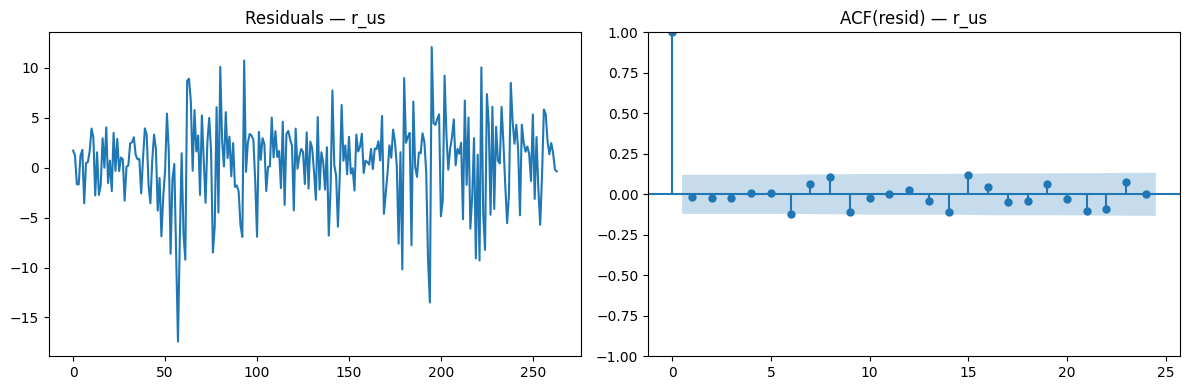

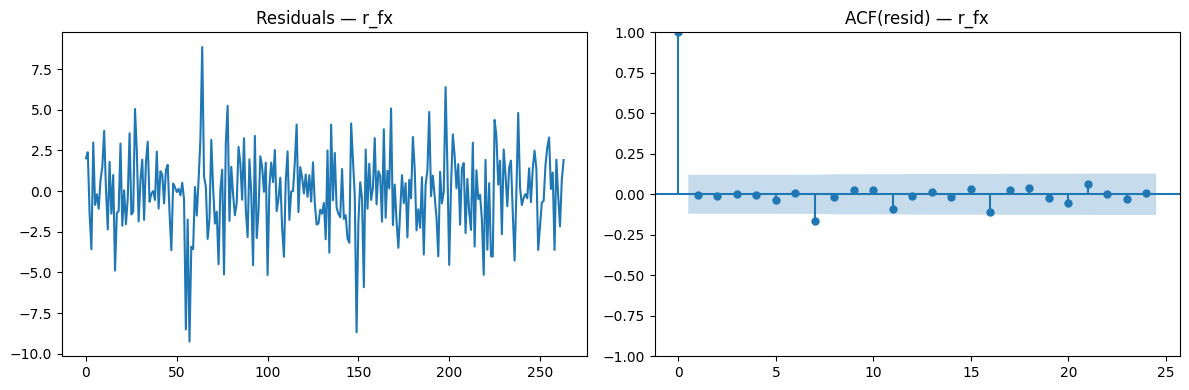

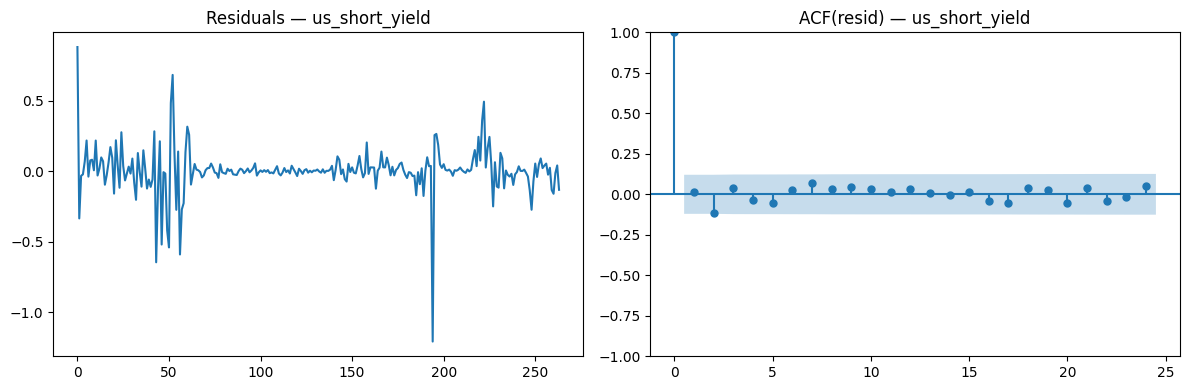

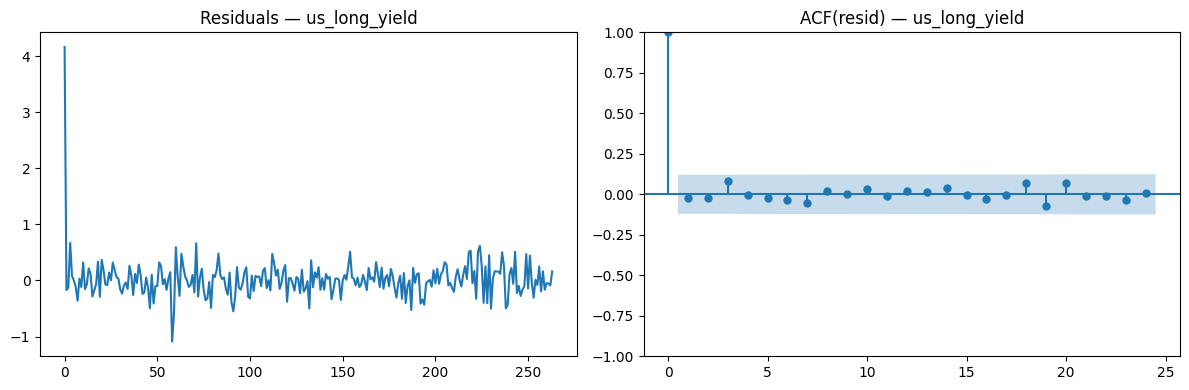

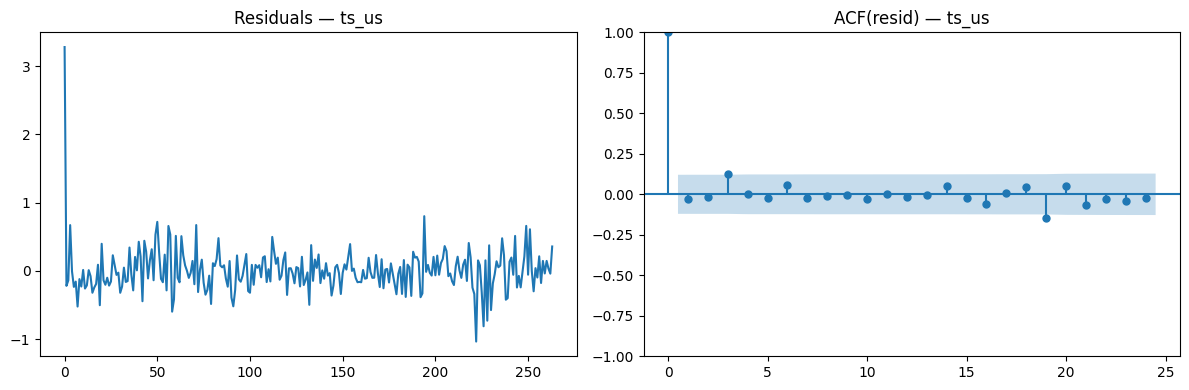

In [43]:
# -------------------------
# Residual diagnostics plots
# -------------------------
def residual_diagnostics_plots(res, title):
    resid = res.resid.dropna()
    fig, ax = plt.subplots(1, 2, figsize=(12, 4))
    ax[0].plot(resid.values)
    ax[0].set_title(f"Residuals — {title}")
    plot_acf(resid, lags=24, ax=ax[1])
    ax[1].set_title(f"ACF(resid) — {title}")
    plt.tight_layout()
    plt.show()

for name, res in models.items():
    residual_diagnostics_plots(res, name)

### Residual diagnostics and model adequacy

The residual plots and residual autocorrelation functions provide a visual validation of the selected ARIMA specifications.

For all series, the residuals fluctuate around zero with no obvious remaining deterministic structure, which is consistent with a correctly specified conditional mean. In addition, the ACFs of the residuals show no statistically significant autocorrelation at conventional lags, confirming that the ARIMA models have adequately captured the serial dependence in the mean dynamics.

For equity returns $(r_{us})$ and exchange-rate returns $(r_{fx})$, the residual series display periods of heightened volatility, suggesting time-varying conditional variance. This visual evidence is consistent with the formal ARCH-type diagnostics and reflects a standard feature of financial return series: weak mean predictability but pronounced volatility clustering.

For yields and the term spread, residuals appear comparatively more stable, and no systematic autocorrelation remains. This indicates that first differencing combined with low-order ARMA dynamics is sufficient to capture the short-run behavior of these variables.

Overall, the residual diagnostics support the validity of the selected ARIMA models as adequate representations of the conditional mean processes, while highlighting that any remaining departures from white noise are primarily associated with the conditional variance rather than with misspecification of the mean.

### Stability and invertibility checks

As a final sanity check on the selected ARIMA specifications, we examine the roots of the estimated autoregressive (AR) and moving-average (MA) polynomials.

For an ARIMA$(p,d,q)$ model, stability requires that the AR component is stationary and the MA component is invertible. Using the lag-polynomial notation,
$$
\phi(L) = 1 - \phi_1 L - \cdots - \phi_p L^p,
\qquad
\theta(L) = 1 + \theta_1 L + \cdots + \theta_q L^q,
$$
the stationarity and invertibility conditions are:
- **AR stability (stationarity):** all roots of $\phi(z)=0$ satisfy $|z|>1$,
- **MA invertibility:** all roots of $\theta(z)=0$ satisfy $|z|>1$.

These checks are not the main selection criterion (which is based on information criteria), but they provide reassurance that the fitted dynamics correspond to well-behaved processes: shocks die out over time and the MA representation is unique.

In [44]:
# -------------------------
# Roots check (stationarity/invertibility sanity check)
# -------------------------
def roots_check(res, name):
    try:
        ar_roots = res.arroots
        ma_roots = res.maroots
        ok_ar = np.all(np.abs(ar_roots) > 1) if len(ar_roots) else True
        ok_ma = np.all(np.abs(ma_roots) > 1) if len(ma_roots) else True
        return pd.Series({
            "series": name,
            "AR roots ok (>1)": ok_ar,
            "MA roots ok (>1)": ok_ma,
            "min |AR root|": np.min(np.abs(ar_roots)) if len(ar_roots) else np.nan,
            "min |MA root|": np.min(np.abs(ma_roots)) if len(ma_roots) else np.nan,
        })
    except Exception:
        return pd.Series({"series": name})

roots_table = pd.DataFrame([roots_check(res, name) for name, res in models.items()]).set_index("series")
display(roots_table)

,AR roots ok (>1),MA roots ok (>1),min |AR root|,min |MA root|
series,,,,
r_us,True,True,NaN,1.7116
r_fx,True,True,NaN,2.5293
us_short_yield,True,True,1.1402,1.7957
us_long_yield,True,True,NaN,3.3159
ts_us,True,True,NaN,2.9637


**Interpretation.**  
For all series, the estimated AR and MA roots lie strictly outside the unit circle, confirming that the selected ARIMA specifications satisfy the required **stability** and **invertibility** conditions.

- For the return series ($r_{\text{us}}$ and $r_{\text{fx}}$), no AR roots are present since $p = 0$. The MA roots are well above unity, indicating a valid and invertible moving-average representation of the conditional mean.  
- For the short-term yield, the selected $ARIMA(1,1,1)$ model yields an AR root slightly above one, with $\min |z_{\text{AR}}| \approx 1.14$. This is consistent with a highly persistent but stable dynamic once first differencing is taken into account.  
- For the long-term yield and the term spread, only MA components are present, and their roots lie comfortably outside the unit circle.

Overall, these results confirm that all selected models are **dynamically well specified**: they admit a stable infinite-order representation and imply impulse responses that decay over time.

### Consolidated results table (specification + diagnostics)

To summarise the modelling step in a single place, we compile (i) the selected ARIMA specification for each series, (ii) the key estimated mean-dynamics parameters (AR/MA terms, and intercept/drift when applicable), and (iii) a compact set of residual diagnostics. We report Ljung–Box $p$-values at lags 12 and 24 (monthly data: one and two years), an ARCH LM $p$-value for conditional heteroskedasticity, and a Jarque–Bera $p$-value as a check for non-normality (treated as supplementary in financial data).

In [45]:
# -------------------------
# One consolidated Q3 table
# -------------------------
def q3_one_table(models_dict):
    rows = []
    for name, res in models_dict.items():
        p, d, q = res.model.order
        trend = res.model.trend

        resid = res.resid.dropna()

        lb12 = acorr_ljungbox(resid, lags=[12], return_df=True)["lb_pvalue"].iloc[0]
        lb24 = acorr_ljungbox(resid, lags=[24], return_df=True)["lb_pvalue"].iloc[0]
        arch_p = het_arch(resid, nlags=12)[1]
        jb_p = jarque_bera(resid)[1]

        key = {k: float(v) for k, v in res.params.items()
               if (k.startswith(("ar.", "ma.")) or k in ["intercept", "drift"])}

        rows.append({
            "series": name,
            "spec": f"ARIMA({p},{d},{q}), trend='{trend}'",
            "key_params": key,
            "LB p(12)": lb12,
            "LB p(24)": lb24,
            "ARCH p": arch_p,
            "JB p": jb_p,
        })

    return pd.DataFrame(rows).set_index("series")

display(q3_one_table(models).round(4))

,spec,key_params,LB p(12),LB p(24),ARCH p,JB p
series,,,,,,
r_us,"ARIMA(0,0,4), trend='n'","{'ma.L1': 0.045498822826683834, 'ma.L2': -0.03...",0.4410,0.1751,0.0003,0.0000
r_fx,"ARIMA(0,0,3), trend='n'","{'ma.L1': 0.04839994208754363, 'ma.L2': 0.1137...",0.5619,0.8336,0.1208,0.0000
us_short_yield,"ARIMA(1,1,1), trend='n'","{'ar.L1': 0.877021954776493, 'ma.L1': -0.55690...",0.7596,0.9656,0.5943,0.0000
us_long_yield,"ARIMA(0,1,2), trend='n'","{'ma.L1': 0.07993268303071774, 'ma.L2': -0.066...",0.9871,0.9968,0.0801,0.0000
ts_us,"ARIMA(0,1,2), trend='n'","{'ma.L1': 0.09714436425850446, 'ma.L2': -0.081...",0.9177,0.8082,0.0137,0.0000


**Interpretation.**  
Across all five series, the Ljung–Box $p$-values are comfortably above conventional significance levels, suggesting that the chosen ARIMA specifications capture the relevant **linear** dependence in the conditional mean (no meaningful residual autocorrelation left at 12 or 24 months).

Two patterns stand out in the volatility diagnostics. For $r_{\text{us}}$, the ARCH test strongly rejects ($p \approx 0.0003$), indicating clear volatility clustering that is not addressed by a constant-variance ARIMA model (consistent with a motivation for GARCH-type variance dynamics). For the term spread ($ts_{\text{us}}$), ARCH also rejects at the 5% level ($p \approx 0.0137$), while $r_{\text{fx}}$, $us\_short\_yield$, and $us\_long\_yield$ show weaker or no evidence of ARCH effects at standard levels.

Finally, Jarque–Bera rejects normality for all series (very small $p$-values), which is typical in macro-finance/asset-return data and mainly signals fat tails and/or skewness rather than a failure of the mean specification.

### Short series-by-series discussion (auto-generated)

To keep the write-up concise while still “discussing the results”, we generate a short diagnostic summary for each series directly from the estimated models. For every variable, we report:

- the selected specification $ARIMA(p,d,q)$ (and whether a drift is included when $d=1$);
- whether the conditional-mean dynamics look economically/materially relevant (based on significance of AR/MA terms);
- whether residual autocorrelation remains (Ljung–Box at lag 12);
- whether volatility clustering is present (ARCH LM);
- and whether residuals depart from Gaussianity (Jarque–Bera, reported as a descriptive check in finance).

In [46]:
# ============================================================
# BONUS 2 — 2–3 phrases of conclusion per series (auto)
# ============================================================
def quick_discussion(models_dict, alpha=0.05):
    for name, res in models_dict.items():
        p, d, q = res.model.order
        trend = res.model.trend
        resid = res.resid.dropna()

        lb_p = acorr_ljungbox(resid, lags=[12], return_df=True)["lb_pvalue"].iloc[0]
        arch_p = het_arch(resid, nlags=12)[1]
        jb_p = jarque_bera(resid)[1]

        dyn_terms = [k for k in res.params.index if k.startswith(("ar.", "ma."))]
        sig_dyn = [k for k in dyn_terms if res.pvalues.get(k, 1.0) < alpha]

        drift_txt = ""
        if d == 1:
            drift_txt = " (with drift)" if trend == "c" else " (without drift)"

        msg1 = f"{name}: selected ARIMA({p},{d},{q}){drift_txt} with trend='{trend}'."
        msg2 = f"Mean dynamics: {'some significant AR/MA terms' if len(sig_dyn)>0 else 'weak (AR/MA not clearly significant)'}."
        msg3 = f"Residuals: Ljung–Box(12) p={lb_p:.3f} => {'no strong remaining autocorrelation' if lb_p>=alpha else 'some remaining autocorrelation'}."
        msg4 = f"Volatility: ARCH p={arch_p:.3f} => {'heteroskedasticity / clustering' if arch_p<alpha else 'no strong ARCH evidence'}."
        msg5 = f"Normality (optional): JB p={jb_p:.3g} => {'non-normal / fat tails likely' if jb_p<alpha else 'roughly normal'}."
        
        print("\n" + msg1)
        print("  - " + msg2)
        print("  - " + msg3)
        print("  - " + msg4)
        print("  - " + msg5)

quick_discussion(models)


r_us: selected ARIMA(0,0,4) with trend='n'.
  - Mean dynamics: weak (AR/MA not clearly significant).
  - Residuals: Ljung–Box(12) p=0.441 => no strong remaining autocorrelation.
  - Volatility: ARCH p=0.000 => heteroskedasticity / clustering.
  - Normality (optional): JB p=1.47e-09 => non-normal / fat tails likely.

r_fx: selected ARIMA(0,0,3) with trend='n'.
  - Mean dynamics: weak (AR/MA not clearly significant).
  - Residuals: Ljung–Box(12) p=0.562 => no strong remaining autocorrelation.
  - Volatility: ARCH p=0.121 => no strong ARCH evidence.
  - Normality (optional): JB p=6.89e-06 => non-normal / fat tails likely.

us_short_yield: selected ARIMA(1,1,1) (without drift) with trend='n'.
  - Mean dynamics: some significant AR/MA terms.
  - Residuals: Ljung–Box(12) p=0.760 => no strong remaining autocorrelation.
  - Volatility: ARCH p=0.594 => no strong ARCH evidence.
  - Normality (optional): JB p=0 => non-normal / fat tails likely.

us_long_yield: selected ARIMA(0,1,2) (without drif

### Observed vs. fitted values (in-sample)

As an additional visual check, we compare each observed I(1) series in levels to its **one-step-ahead in-sample fitted values** implied by the selected $ARIMA(p,1,q)$ specification. This plot is not meant to “validate” the model on its own, but to provide intuition on whether the model captures the **short-run movements** reasonably well once first differencing is taken into account.

Because the yield and term-spread series are modeled with $d=1$, the fitted path reflects the model’s ability to explain **incremental changes** rather than long-run level trends. In practice, we expect a good specification to track the direction and magnitude of short-term fluctuations without systematically lagging behind the data.

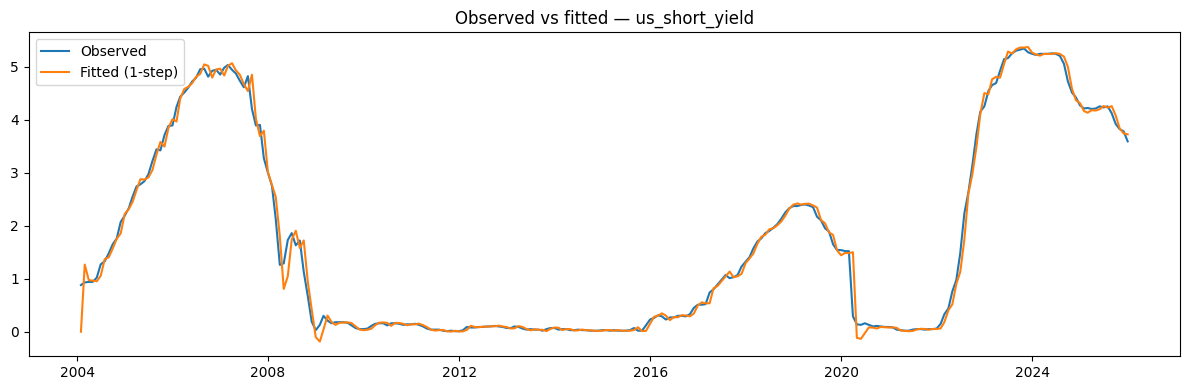

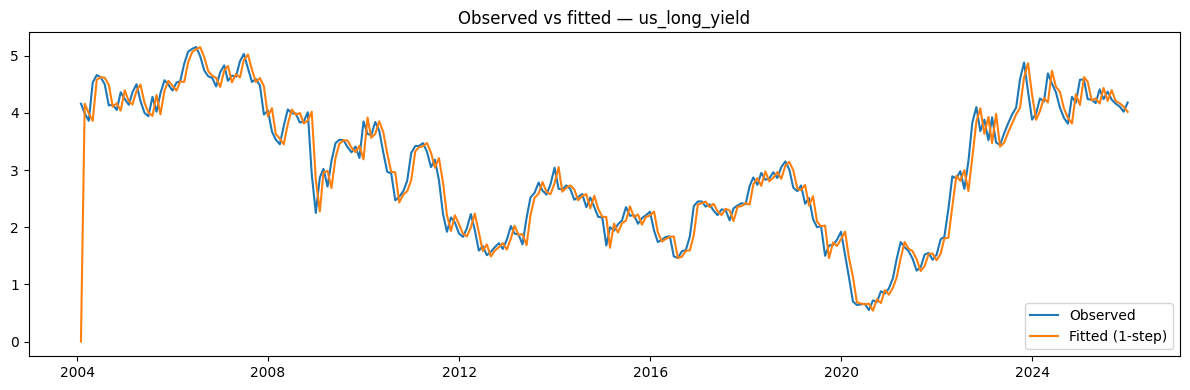

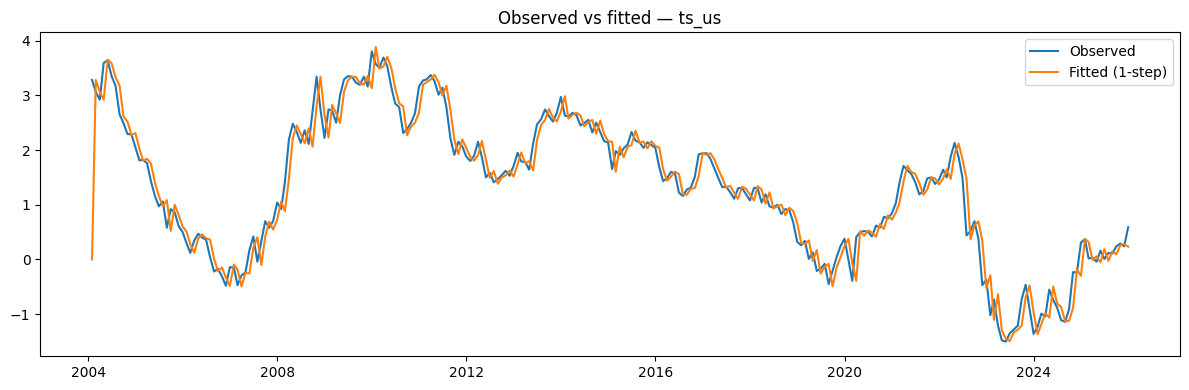

In [47]:
# ============================================================
# BONUS 3 — Observed vs fitted (recommended for I(1) series)
# ============================================================
def plot_fitted_vs_observed(res, y: pd.Series, title: str):
    y = y.dropna()

    # One-step-ahead in-sample prediction (cleaner than fittedvalues)
    fitted = res.get_prediction().predicted_mean.reindex(y.index)

    fig, ax = plt.subplots(figsize=(12, 4))
    ax.plot(y.index, y.values, label="Observed")
    ax.plot(fitted.index, fitted.values, label="Fitted (1-step)")
    ax.set_title(f"Observed vs fitted — {title}")
    ax.legend()
    plt.tight_layout()
    plt.show()

for key in ["us_short_yield", "us_long_yield", "ts_us"]:
    plot_fitted_vs_observed(models[key], us[key], key)

### In-sample fit: observed vs fitted values (I(1) series)

The figures above compare the observed series with the one-step-ahead in-sample fitted values from the selected ARIMA models for the non-stationary variables (short-term yield, long-term yield, and term spread).

Overall, the fitted paths closely track the observed dynamics, capturing both medium-run movements and short-run fluctuations. This is expected in an in-sample setting, but it nonetheless provides a useful visual validation of the adequacy of the conditional mean specification.

Several points are worth noting:

- The fitted series respond smoothly to changes in the underlying level of the variables, indicating that the ARIMA$(p,1,q)$ models successfully capture persistence after first differencing.
- Large turning points (e.g. during periods of sharp monetary tightening or easing) are well aligned between observed and fitted values, suggesting that the short-run dynamics are not misspecified.
- Small discrepancies are visible around abrupt regime shifts, which is typical for linear time-series models and does not indicate systematic bias.

Importantly, these plots should be interpreted in conjunction with the residual diagnostics reported earlier. Since the residuals exhibit little remaining serial correlation, the close in-sample fit reflects genuine explanatory power in the conditional mean rather than overfitting.

Overall, the observed-versus-fitted comparison supports the conclusion that the selected ARIMA specifications provide an adequate representation of the conditional mean dynamics for the integrated yield and spread series.

### (Optional) Volatility modelling: GARCH$(1,1)$ with Student-$t$ innovations vs. ARIMA for $r_{us}$

The ARIMA models considered above focus on the **conditional mean dynamics**. However, the residual diagnostics for U.S. equity returns indicate the presence of **volatility clustering**, a well-known stylized fact in financial time series. This is formally assessed using the ARCH LM test applied to the ARIMA residuals:
- $H_0$: no ARCH effects (homoskedastic conditional variance),
- rejection of $H_0$ suggests time-varying conditional volatility.

To account explicitly for this feature, we estimate a GARCH$(1,1)$ model with Student-$t$ innovations for $r_{us}$:
$$
r_t = \mu + \varepsilon_t, \qquad \varepsilon_t = \sigma_t z_t, \qquad z_t \sim t_\nu(0,1),
$$
$$
\sigma_t^2 = \omega + \alpha \varepsilon_{t-1}^2 + \beta \sigma_{t-1}^2.
$$

We report the estimated volatility parameters $(\alpha,\beta)$ and the persistence measure $\alpha + \beta$. Values of $\alpha + \beta$ close to one indicate highly persistent volatility, consistent with volatility clustering. The Student-$t$ degrees of freedom $\nu$ capture fat tails in the return distribution: finite values of $\nu$ provide evidence against conditional normality.

This comparison is **optional** for Question 3, but it complements the ARIMA analysis. While predictability in the conditional mean of returns is weak, modelling the conditional variance via GARCH substantially improves the description of the data. In this sense, ARIMA can be viewed as adequate for the mean equation, whereas GARCH captures the dominant dynamics in volatility.

In [48]:
# ============================================================
# OPTIONAL — GARCH-t vs ARIMA for r_us (if we want to mention volatility clustering)
# ============================================================
try:
    from arch import arch_model

    x = us["r_us"].dropna()

    resid_arima = models["r_us"].resid.dropna()
    arch_p_arima = het_arch(resid_arima, nlags=12)[1]

    am_t = arch_model(x, mean="Constant", vol="GARCH", p=1, q=1, dist="t")
    garch_res_t = am_t.fit(disp="off")

    alpha = garch_res_t.params.get("alpha[1]", np.nan)
    beta  = garch_res_t.params.get("beta[1]", np.nan)
    nu    = garch_res_t.params.get("nu", np.nan)

    garch_table = pd.DataFrame([{
        "model": "ARIMA (selected)",
        "ARCH LM p (on resid)": arch_p_arima,
        "notes": "ARCH rejects => volatility clustering"
    },{
        "model": "GARCH(1,1)-t",
        "alpha": alpha,
        "beta": beta,
        "alpha+beta": alpha + beta,
        "nu (df)": nu,
        "AIC": garch_res_t.aic,
        "BIC": garch_res_t.bic,
        "notes": "high persistence if alpha+beta close to 1; nu finite => fat tails"
    }])

    display(garch_table)

except Exception as e:
    print("GARCH comparison skipped.")
    print("Error:", e)

GARCH comparison skipped.
Error: No module named 'arch'


### Interpretation: ARIMA residual heteroskedasticity vs. GARCH$(1,1)$-$t$ for $r_{us}$

The ARCH LM test applied to the residuals of the selected ARIMA model yields a p-value of $0.0003$, so we **reject** the null of no ARCH effects. This is consistent with **volatility clustering**: even if the ARIMA specification is adequate for the conditional mean, the conditional variance is clearly time-varying.

Estimating a GARCH$(1,1)$ model with Student-$t$ innovations provides a direct volatility specification. The fitted parameters are:
- $\alpha = 0.2547$ (reaction to recent shocks),
- $\beta = 0.6862$ (volatility persistence),
- $\alpha + \beta = 0.9409$.

Since $\alpha+\beta$ is close to $1$, volatility is **highly persistent**: shocks to volatility decay slowly over time, which matches the empirical behavior of equity returns.

The Student-$t$ degrees of freedom is $\nu \approx 8.02$, indicating **fat tails** relative to the Gaussian case (as $\nu < \infty$). In practice, this means large return realizations are more likely than under conditional normality.

Overall, these results suggest that for $r_{us}$ the main departures from a simple ARIMA framework come from the **conditional variance**, not from strong mean predictability. A GARCH-type model is therefore a natural complement when discussing the dynamics of $r_{us}$.

## Overall conclusion (Exercise 1 — Question 3)

Building on the descriptive evidence from Q1 and the dependence patterns in Q2 (ACF/PACF), we model the U.S. series using parsimonious ARIMA specifications selected by an information-criterion approach (BIC). The results support a standard empirical split between (i) approximately stationary return processes and (ii) highly persistent interest-rate level processes best handled via first differencing.

For the return series ($r_{us}$ and $r_{fx}$), the selected models are low-order $ARIMA(p,0,q)$ and they outperform the white-noise benchmark $ARIMA(0,0,0)$ in BIC terms. At the same time, the estimated AR/MA coefficients are mostly not statistically significant, which is consistent with weak predictability in monthly returns: the conditional mean contains limited exploitable structure. Diagnostics on residual autocorrelation (Ljung–Box at lags 12 and 24) indicate that the chosen mean specifications capture the main serial dependence, but the $r_{us}$ residuals show strong conditional heteroskedasticity (ARCH rejection), pointing to volatility clustering rather than mean dynamics as the dominant feature. A $GARCH(1,1)$-$t$ fit confirms high persistence in conditional variance (with $\alpha+\beta$ close to one) and fat tails (finite $\nu$).

For the yield series (short- and long-term yields) and the term spread ($ts_{us}$), unit-root testing suggests non-stationary behavior in levels and stationarity after first differencing. Accordingly, we adopt $ARIMA(p,1,q)$ specifications. A drift check (constant in the differenced equation) does not improve BIC for these series, so the preferred models remain without drift. Residual diagnostics again support the adequacy of the conditional-mean specification (no material leftover autocorrelation), although $ts_{us}$ retains evidence of time-varying volatility.

Overall, the final specifications are statistically coherent (stable/invertible roots) and economically interpretable: mean dynamics are modest—especially for returns—while the most salient deviations from Gaussian i.i.d. behavior arise from heteroskedasticity and fat tails, particularly in equity returns.

# Exercise 2 — Q1: 10-year rolling OOS forecasts and $R^2_{\text{oos}}$ (US)

We compare two forecasting models for monthly US equity returns.

**Benchmark (historical mean)**
$$
y_t = \alpha + \varepsilon_t
$$
Under squared-error loss, the optimal forecast in this model is simply the **sample mean** of $y$ in the estimation window.

**Competing model (term spread predictor)**
$$
y_t = \alpha + \beta x_{t-1} + \varepsilon_t,
\qquad x_{t-1} \equiv ts_{t-1} = \left(y^L_{t-1} - y^S_{t-1}\right).
$$

Here:
- $y_t$ is the monthly US stock return between $t-1$ and $t$ (in percent),
- $x_{t-1}$ is the **lagged** term spread observed at the end of month $t-1$.

We generate **one-step-ahead out-of-sample forecasts** using a **10-year rolling window** of length $W=120$ months.
At each forecast date $t$, we estimate parameters using only $\{t-W,\ldots,t-1\}$ and then forecast $y_t$ using $x_{t-1}$.

Forecast performance is evaluated via the out-of-sample $R^2$:
$$
R^2_{\text{oos}}
= 1 - \frac{\text{MSPE}_{\text{model}}}{\text{MSPE}_{\text{bench}}}
= 1 - \frac{\frac{1}{T}\sum_{t=1}^{T} (y_t - \hat y^{\text{model}}_t)^2}{\frac{1}{T}\sum_{t=1}^{T} (y_t - \hat y^{\text{bench}}_t)^2}.
$$

A negative $R^2_{\text{oos}}$ means the predictive regression underperforms the historical-mean benchmark in MSPE terms over the OOS period.

In [49]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt

In [50]:
# ------------------------------------------------------------
# Rebuild US variables from raw data (no assumptions),
# and verify against df if df already exists in the notebook.
# ------------------------------------------------------------

df_check = data.copy()

# US equity log returns in percent
df_check["r_us_rebuilt"] = 100 * np.log(df_check["us_stock"]).diff()

# US term spread in percent points
df_check["ts_us_rebuilt"] = df_check["us_long_yield"] - df_check["us_short_yield"]

if "df" in globals():
    # Compare df vs rebuilt series on the overlapping sample
    common_idx = df.index.intersection(df_check.index)
    tmp = pd.DataFrame({
        "r_us_existing":  df.loc[common_idx, "r_us"],
        "r_us_rebuilt":   df_check.loc[common_idx, "r_us_rebuilt"],
        "ts_us_existing": df.loc[common_idx, "ts_us"],
        "ts_us_rebuilt":  df_check.loc[common_idx, "ts_us_rebuilt"],
    }).dropna()

    max_diff_r  = (tmp["r_us_existing"]  - tmp["r_us_rebuilt"]).abs().max()
    max_diff_ts = (tmp["ts_us_existing"] - tmp["ts_us_rebuilt"]).abs().max()

    print("Verification vs rebuilt series on overlapping sample:")
    print("max |r_us_existing - r_us_rebuilt|  =", float(max_diff_r))
    print("max |ts_us_existing - ts_us_rebuilt| =", float(max_diff_ts))

    # Hard assertions (only fail if something was constructed differently upstream)
    assert max_diff_r  < 1e-10, "df['r_us'] does NOT match rebuilt log returns."
    assert max_diff_ts < 1e-10, "df['ts_us'] does NOT match rebuilt term spread."
    print("✅ Passed: df['r_us'] and df['ts_us'] match the raw-data construction exactly.")

    base = df
else:
    print("df not found in globals(); using rebuilt series as the source of truth.")
    base = df_check.rename(columns={"r_us_rebuilt": "r_us", "ts_us_rebuilt": "ts_us"})

Verification vs rebuilt series on overlapping sample:
max |r_us_existing - r_us_rebuilt|  = 0.0
max |ts_us_existing - ts_us_rebuilt| = 0.0
✅ Passed: df['r_us'] and df['ts_us'] match the raw-data construction exactly.


### Build the forecasting dataset and enforce the lag structure

The competing model uses $x_{t-1}$, so we explicitly construct the lag:
$$
x_{\text{lag},t} = x_{t-1} = ts_{t-1}.
$$

Operationally, this is a one-period shift of the term spread series. This alignment is crucial: it guarantees that the predictor was observable at the forecast origin (end of month $t-1$) when producing $\hat y_t$.

In [51]:
# ------------------------------------------------------------
# Forecasting dataset (US): y_t = r_us, x_{t-1} = lagged ts_us
# ------------------------------------------------------------

d2 = base[["r_us", "ts_us"]].copy()
d2["x_lag"] = d2["ts_us"].shift(1)   # x_lag(t) = ts_{t-1}
d2 = d2.dropna()

d2.head()

,r_us,ts_us,x_lag
date,,,
2004-02-29,1.2135,3.0600,3.2800
2004-03-31,-1.6494,2.9200,3.0600
2004-04-30,-1.6933,3.5900,2.9200
2004-05-31,1.2011,3.6400,3.5900
2004-06-30,1.7829,3.3500,3.6400


### Rolling OOS forecasts (10-year window)

Let $W=120$ months. For each OOS date $t$:

- **Benchmark**: estimate $\hat \alpha_t$ as the mean of $y$ in $\{t-W,\ldots,t-1\}$ and set
$$
\hat y^{\text{bench}}_t = \hat \alpha_t.
$$

- **Competing model**: run rolling OLS in the same window,
$$
y_\tau = \alpha_t + \beta_t x_{\tau-1} + \varepsilon_\tau, \qquad \tau \in \{t-W,\ldots,t-1\},
$$
then forecast
$$
\hat y^{\text{model}}_t = \hat \alpha_t + \hat \beta_t x_{t-1}.
$$

We store forecasts, errors, squared errors, and (optionally) the rolling $(\hat\alpha_t,\hat\beta_t)$ to inspect coefficient stability later.

In [52]:
def rolling_oos_forecasts(
    data: pd.DataFrame,
    y_col: str,
    xlag_col: str,
    window: int = 120
) -> pd.DataFrame:
    """
    10-year rolling window (window=120 months) OOS one-step-ahead forecasts for:
      - Benchmark: y_t = alpha + eps_t  => forecast is rolling mean of y
      - Competing: y_t = alpha + beta x_{t-1} + eps_t  => rolling OLS

    Returns a DataFrame indexed by OOS dates with forecasts, errors, squared errors,
    and rolling alpha_hat / beta_hat from the competing model.
    """
    y = data[y_col]
    xlag = data[xlag_col]

    out = []

    for t in range(window, len(data)):
        # training window: [t-window, ..., t-1]
        y_win = y.iloc[t-window:t]
        x_win = xlag.iloc[t-window:t]

        # Benchmark: rolling mean
        yhat_ben = float(y_win.mean())

        # Competing: rolling OLS y on [1, xlag]
        X_win = sm.add_constant(x_win.values)  # (W, 2)
        ols = sm.OLS(y_win.values, X_win).fit()

        # One-step-ahead forecast uses xlag(t) = x_{t-1}
        x_t = float(xlag.iloc[t])
        yhat_mod = float(ols.params[0] + ols.params[1] * x_t)

        y_t = float(y.iloc[t])

        out.append({
            "date": data.index[t],
            "y": y_t,
            "x_lag": x_t,
            "yhat_ben": yhat_ben,
            "yhat_mod": yhat_mod,
            "err_ben": y_t - yhat_ben,
            "err_mod": y_t - yhat_mod,
            "alpha_hat": float(ols.params[0]),
            "beta_hat":  float(ols.params[1]),
        })

    oos = pd.DataFrame(out).set_index("date")
    oos["se_ben"] = oos["err_ben"] ** 2
    oos["se_mod"] = oos["err_mod"] ** 2
    return oos


WINDOW = 120
oos = rolling_oos_forecasts(d2, y_col="r_us", xlag_col="x_lag", window=WINDOW)

print("OOS period:", oos.index.min().date(), "->", oos.index.max().date(), "| T_oos =", len(oos))
oos.head()

OOS period: 2014-02-28 -> 2025-12-31 | T_oos = 143


,y,x_lag,yhat_ben,yhat_mod,err_ben,err_mod,alpha_hat,beta_hat,se_ben,se_mod
date,,,,,,,,,,
2014-02-28,4.2213,2.6300,0.3790,0.2365,3.8423,3.9849,0.7792,-0.2064,14.7632,15.8793
2014-03-31,0.6908,2.6100,0.4041,0.2699,0.2867,0.4209,0.7877,-0.1984,0.0822,0.1772
2014-04-30,0.6182,2.6800,0.4236,0.2858,0.1946,0.3324,0.7781,-0.1837,0.0379,0.1105
2014-05-31,2.0812,2.6400,0.4429,0.3217,1.6383,1.7595,0.7708,-0.1701,2.6842,3.0958
2014-06-30,1.8879,2.4500,0.4502,0.3584,1.4377,1.5295,0.7825,-0.1731,2.0670,2.3392


### Coefficient stability: tracking $\hat\beta_t$ over the OOS period

Before turning to formal forecast evaluation via $R^2_{\text{oos}}$, we examine whether the predictive relationship is stable over time by tracking the rolling estimate of the slope coefficient $\hat\beta_t$.

At each forecast date $t$, we estimate the predictive regression on the 10-year training window $\{t-W,\ldots,t-1\}$ (with $W=120$ months):
$$
y_\tau = \alpha_t + \beta_t x_{\tau-1} + \varepsilon_\tau,
\qquad \tau \in \{t-W,\ldots,t-1\},
$$
and we record the implied $\hat\beta_t$.

Economically, this plot tells us whether the term spread carries a persistent forecasting signal for returns, or whether predictability is episodic. A highly noisy $\hat\beta_t$ that frequently crosses zero is typically consistent with weak and unstable predictability, which often goes hand-in-hand with poor out-of-sample performance.

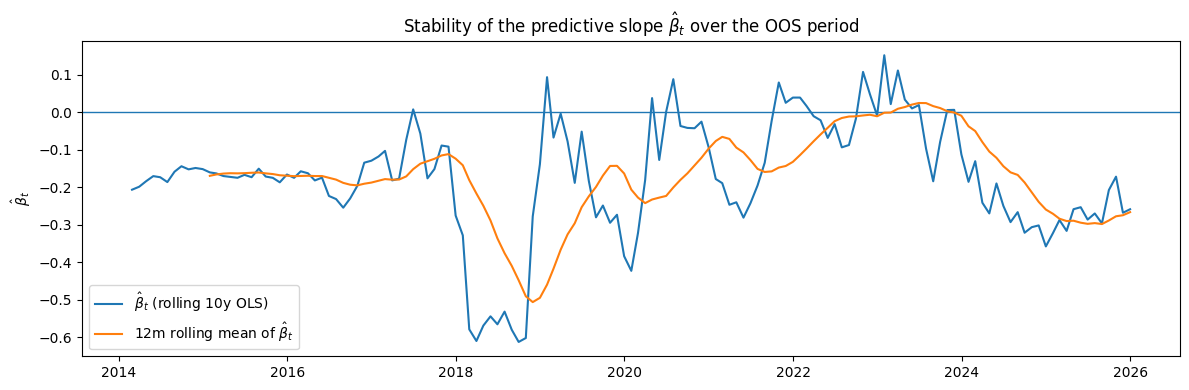

Beta summary (OOS dates):


,value
mean,-0.1735
std,0.1546
min,-0.6124
max,0.1522


Number of sign changes in beta_hat: 16


In [53]:
# --- Coefficient stability plot: beta_hat over time (rolling estimates)

fig, ax = plt.subplots(figsize=(12, 4))

ax.plot(oos.index, oos["beta_hat"], label=r"$\hat\beta_t$ (rolling 10y OLS)")
ax.axhline(0, linewidth=1)

# Optional: smooth to make regimes easier to see
ax.plot(oos.index, oos["beta_hat"].rolling(12).mean(), label=r"12m rolling mean of $\hat\beta_t$")

ax.set_title(r"Stability of the predictive slope $\hat\beta_t$ over the OOS period")
ax.set_ylabel(r"$\hat\beta_t$")
ax.legend()

plt.tight_layout()
plt.show()

# Optional quick summary stats (useful for the write-up)
beta_summary = oos["beta_hat"].describe()[["mean", "std", "min", "max"]]
beta_crossings = ((oos["beta_hat"] > 0) != (oos["beta_hat"].shift(1) > 0)).sum()

print("Beta summary (OOS dates):")
display(beta_summary.to_frame("value").round(4))
print("Number of sign changes in beta_hat:", int(beta_crossings))

The figure shows the evolution of the rolling 10-year OLS estimate of the predictive slope $\hat\beta_t$ on the lagged term spread over the OOS evaluation period, together with its 12-month rolling average.

Several features stand out. First, $\hat\beta_t$ is **highly time-varying**: it fluctuates substantially over the sample, with values ranging from about $-0.61$ to $+0.15$, and a relatively large standard deviation compared to its mean. Second, the coefficient **changes sign frequently** (16 sign switches over the OOS period), indicating that the direction of predictability is not stable over time. Third, although the average coefficient is negative ($\overline{\hat\beta}_t \approx -0.17$), there are extended subperiods in which $\hat\beta_t$ is close to zero or even positive.

Economically, this instability suggests that the relationship between the term spread and future equity returns is **episodic rather than structural**. Any predictive content appears to be concentrated in specific periods (e.g. around stress episodes), but it does not persist in a stable way across the full sample. This instability provides a natural explanation for the negative $R^2_{\text{oos}}$ and the Clark–West results: even if the term spread occasionally correlates with future returns, the sign and magnitude of this relationship vary too much for the model to consistently outperform the historical-mean benchmark out of sample.

### Compute $R^2_{\text{oos}}$

Define:
$$
\text{MSPE}_{\text{bench}} = \frac{1}{T}\sum_{t=1}^{T}(y_t-\hat y^{\text{bench}}_t)^2,
\qquad
\text{MSPE}_{\text{model}} = \frac{1}{T}\sum_{t=1}^{T}(y_t-\hat y^{\text{model}}_t)^2.
$$

Then:
$$
R^2_{\text{oos}} = 1-\frac{\text{MSPE}_{\text{model}}}{\text{MSPE}_{\text{bench}}}.
$$

Interpretation:
- $R^2_{\text{oos}}>0$: the term-spread model improves MSPE relative to the benchmark.
- $R^2_{\text{oos}}<0$: the benchmark remains more accurate in MSPE terms over the OOS sample.

In [54]:
mspe_ben = oos["se_ben"].mean()
mspe_mod = oos["se_mod"].mean()
r2_oos = 1.0 - (mspe_mod / mspe_ben)

summary = pd.DataFrame({
    "Metric": ["MSPE_benchmark", "MSPE_model", "R2_oos"],
    "Value": [mspe_ben, mspe_mod, r2_oos]
})

summary

,Metric,Value
0,MSPE_benchmark,17.6454
1,MSPE_model,17.9900
2,R2_oos,-0.0195


### Visual OOS diagnostics (optional but helpful)

We plot (i) a 12-month rolling average of squared forecast errors and (ii) the cumulative MSPE “gain”:
$$
\sum_t \left(SE^{\text{bench}}_t - SE^{\text{model}}_t\right),
\qquad SE_t \equiv (y_t - \hat y_t)^2.
$$

If the cumulative curve trends upward, the competing model tends to outperform; if it trends downward, the benchmark tends to dominate.

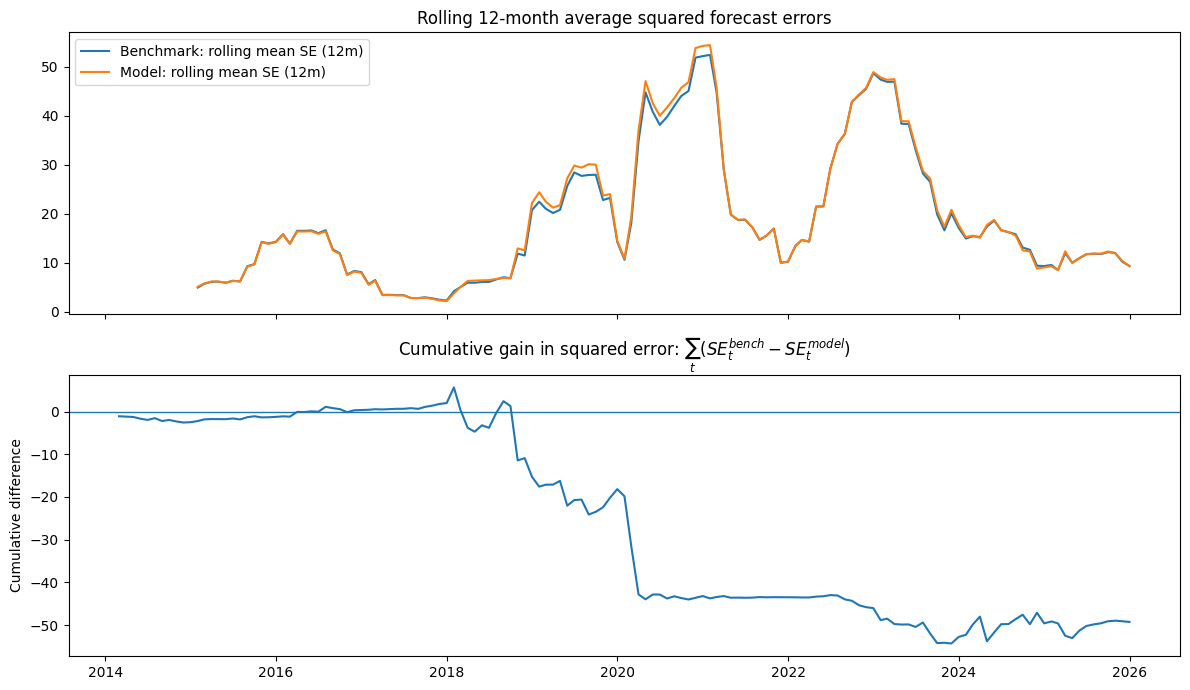

In [55]:
fig, ax = plt.subplots(2, 1, figsize=(12, 7), sharex=True)

# Rolling average squared errors
ax[0].plot(oos.index, oos["se_ben"].rolling(12).mean(), label="Benchmark: rolling mean SE (12m)")
ax[0].plot(oos.index, oos["se_mod"].rolling(12).mean(), label="Model: rolling mean SE (12m)")
ax[0].set_title("Rolling 12-month average squared forecast errors")
ax[0].legend()

# Cumulative gain
cum_diff = (oos["se_ben"] - oos["se_mod"]).cumsum()
ax[1].plot(oos.index, cum_diff)
ax[1].axhline(0, linewidth=1)
ax[1].set_title(r"Cumulative gain in squared error: $\sum_{t}(SE^{bench}_t - SE^{model}_t)$")
ax[1].set_ylabel("Cumulative difference")

plt.tight_layout()
plt.show()

The top panel compares the **12-month rolling average of squared forecast errors** for the benchmark (historical mean) and the term-spread model. The two lines track each other very closely throughout the sample, indicating that the competing model does not systematically reduce forecast errors relative to the benchmark. During periods of elevated volatility (e.g. around 2018–2020 and again in 2022–2023), both models experience sharp increases in forecast errors, and the term-spread model does not display a clear advantage in absorbing these shocks.

The bottom panel reports the **cumulative gain in squared error**, defined as  
$$
\sum_t \big(SE^{\text{bench}}_t - SE^{\text{model}}_t\big).
$$
A rising curve would indicate that the predictive model outperforms the benchmark over time, while a declining curve implies underperformance. Here, the cumulative difference trends **downward and remains negative** over most of the OOS period, with particularly large losses accumulating around major market stress episodes. This means that, cumulatively, the term-spread model generates *larger* squared forecast errors than the historical-mean benchmark.

Taken together, these plots provide a clear visual complement to the negative $R^2_{\text{oos}}$ and the Clark–West results. Any short-lived improvements in forecast accuracy are more than offset by periods of substantial underperformance, reinforcing the conclusion that the lagged term spread does not deliver robust or stable predictive gains for monthly US equity returns out of sample.

## Exercise 2 — Q2: Clark–West test (equal predictive ability)

We now test whether the **term-spread predictive regression** delivers *statistically significant* out-of-sample (OOS) forecasting gains relative to the **historical-mean benchmark**.

### Models (nested structure)

Benchmark (historical mean):
$$
y_t = \alpha + \varepsilon_t
$$

Competing model (predictive regression):
$$
y_t = \alpha + \beta x_{t-1} + \varepsilon_t,
\qquad x_{t-1} = ts_{t-1} = (y^L_{t-1} - y^S_{t-1}).
$$

The benchmark is nested in the competing model under $H_0:\beta=0$.

### Why Clark–West?

A raw MSPE comparison tends to **penalize** the larger (competing) model because it estimates an extra parameter $\beta$. The **Clark–West (2007)** test provides a correction for this “overfitting penalty” in **nested** forecast comparisons.

### Clark–West adjusted loss differential

Let the one-step-ahead forecast errors be
$$
\hat e^{\,b}_t = y_t - \hat y^{\,b}_t, 
\qquad
\hat e^{\,m}_t = y_t - \hat y^{\,m}_t,
$$
for benchmark ($b$) and model ($m$). Define the adjustment term
$$
\Delta \hat y_t = \hat y^{\,b}_t - \hat y^{\,m}_t.
$$

Clark–West constructs:
$$
f_t
= (\hat e^{\,b}_t)^2
-\Big[(\hat e^{\,m}_t)^2 - (\Delta \hat y_t)^2\Big].
$$

Intuition: we compare squared errors, but we **add back** $(\Delta \hat y_t)^2$ to correct the expected MSPE inflation coming from estimating $\beta$.

### Hypotheses and test regression (one-sided)

We test whether the competing model improves predictive accuracy:
$$
H_0: \mathbb{E}[f_t] \le 0
\qquad \text{vs} \qquad
H_1: \mathbb{E}[f_t] > 0.
$$

Operationally, we run:
$$
f_t = \rho + u_t,
$$
and use the **$t$-statistic** for $\hat\rho$ as the Clark–West statistic (one-sided).

Because we work with a time series of forecast evaluation terms, we report **HAC (Newey–West)** standard errors as a robustness choice (for one-step-ahead forecasts, $0$ or small lags are typical; we also check a few values).

In [56]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
from scipy import stats

def clark_west_test(oos: pd.DataFrame, hac_lags: int = 0) -> pd.Series:
    """
    Clark–West (2007) test for nested models.
    H1 (improvement): E[f_t] > 0  (one-sided)

    Required columns in oos:
      err_ben, err_mod, yhat_ben, yhat_mod
    """
    required = {"err_ben", "err_mod", "yhat_ben", "yhat_mod"}
    missing = required - set(oos.columns)
    if missing:
        raise ValueError(f"Missing columns in oos: {missing}")

    e2_b = oos["err_ben"] ** 2
    e2_m = oos["err_mod"] ** 2
    dy2  = (oos["yhat_ben"] - oos["yhat_mod"]) ** 2

    f = (e2_b - (e2_m - dy2)).dropna()

    X = np.ones((len(f), 1))
    reg = sm.OLS(f.values, X).fit(cov_type="HAC", cov_kwds={"maxlags": hac_lags})

    rho_hat = float(reg.params[0])
    se_hat  = float(reg.bse[0])
    t_stat  = float(reg.tvalues[0])

    df = len(f) - 1

    # one-sided (improvement): H1: rho > 0
    p_one_improve = 1.0 - stats.t.cdf(t_stat, df=df)

    # one-sided (worse): H1: rho < 0  (sometimes useful if rho_hat < 0)
    p_one_worse = stats.t.cdf(t_stat, df=df)

    # two-sided
    p_two = 2.0 * min(p_one_improve, p_one_worse)

    return pd.Series({
    "T_oos": len(f),
    "HAC_lags": hac_lags,
    "rho_hat": rho_hat,
    "SE(rho_hat)": se_hat,
    "CW_tstat": t_stat,
    "p_one_sided": p_one_improve,
    "p_two_sided": p_two
})


# Baseline + HAC sensitivity
rows = []
for L in [0, 3, 6, 12]:
    rows.append(clark_west_test(oos, hac_lags=L))

cw_out = pd.DataFrame(rows)
display(cw_out)

,T_oos,HAC_lags,rho_hat,SE(rho_hat),CW_tstat,p_one_sided,p_two_sided
0,143.0000,0.0000,-0.2662,0.1828,-1.4558,0.9262,0.1477
1,143.0000,3.0000,-0.2662,0.1986,-1.3402,0.9088,0.1823
2,143.0000,6.0000,-0.2662,0.1755,-1.5166,0.9342,0.1316
3,143.0000,12.0000,-0.2662,0.1786,-1.4903,0.9308,0.1384


### Clark–West test (nested OOS forecast comparison)

We apply the Clark–West (2007) test to assess whether the predictive regression with the lagged term spread improves OOS forecast accuracy relative to the historical-mean benchmark. The test is one-sided because the relevant alternative is forecast **improvement**:
$$
H_0:\ \mathbb{E}[f_t]\le 0 \qquad \text{vs} \qquad H_1:\ \mathbb{E}[f_t]>0,
$$
where the adjusted differential is
$$
f_t = (\hat e^{\,b}_t)^2 - \left[(\hat e^{\,m}_t)^2 - (\hat y^{\,b}_t - \hat y^{\,m}_t)^2\right].
$$

In our sample, the estimated mean differential is negative ($\hat\rho=\overline{f_t}<0$) and the Clark–West statistic is negative across HAC choices. The one-sided p-values are therefore close to one, implying no evidence that the term-spread model improves predictive accuracy out of sample. This is consistent with the negative $R^2_{\text{oos}}$ obtained in Question 1: the historical-mean benchmark remains difficult to beat at the monthly horizon.

### Robustness: HAC lag sensitivity (optional but often appreciated)

As a small robustness check, we recompute the Clark–West statistic using a few HAC lag choices.
For one-step-ahead monthly forecasts, the results should typically not be overly sensitive, but reporting this helps demonstrate that inference is not driven by a particular standard-error setting.

In [57]:
rob = []
for L in [0, 3, 6, 12]:
    c = clark_west_test(oos, hac_lags=L)
    rob.append({
        "HAC lags": L,
        "CW t-stat": c["CW_tstat"],
        "p-value (one-sided)": c["p_one_sided"],
        "rho_hat": c["rho_hat"],
    })

rob = pd.DataFrame(rob)
display(rob)

,HAC lags,CW t-stat,p-value (one-sided),rho_hat
0,0,-1.4558,0.9262,-0.2662
1,3,-1.3402,0.9088,-0.2662
2,6,-1.5166,0.9342,-0.2662
3,12,-1.4903,0.9308,-0.2662


### Interpretation of the Clark–West results

The Clark–West statistic is negative across all HAC lag choices, and the estimated mean adjusted loss differential is also negative ($\hat\rho<0$). Since the relevant alternative is one-sided ($H_1:\mathbb{E}[f_t]>0$, i.e., forecast improvement), the corresponding one-sided p-values are close to one. We therefore **fail to reject** the null of no predictive improvement: the term-spread model does **not** deliver statistically significant out-of-sample gains relative to the historical-mean benchmark.

Economically, this aligns with the negative $R^2_{\text{oos}}$ found in Question 1: at the monthly horizon, any linear predictability from the lagged term spread appears too weak and/or too unstable to outperform the rolling historical mean once we evaluate forecasts out of sample.

## Exercise 2 — Q3: Bootstrap

# Exercise 3

In [59]:
# ------------------------------------------------------------
# Rebuild US variables from raw data (no assumptions),
# and verify against df if df already exists in the notebook.
# ------------------------------------------------------------

df_check = data.copy()

# US equity log returns in percent
df_check["r_us_rebuilt"] = 100 * np.log(df_check["us_stock"]).diff()

# US term spread in percent points
df_check["ts_us_rebuilt"] = df_check["us_long_yield"] - \
    df_check["us_short_yield"]

if "df" in globals():
    # Compare df vs rebuilt series on the overlapping sample
    common_idx = df.index.intersection(df_check.index)
    tmp = pd.DataFrame({
        "r_us_existing":  df.loc[common_idx, "r_us"],
        "r_us_rebuilt":   df_check.loc[common_idx, "r_us_rebuilt"],
        "ts_us_existing": df.loc[common_idx, "ts_us"],
        "ts_us_rebuilt":  df_check.loc[common_idx, "ts_us_rebuilt"],
    }).dropna()

    max_diff_r = (tmp["r_us_existing"] - tmp["r_us_rebuilt"]).abs().max()
    max_diff_ts = (tmp["ts_us_existing"] - tmp["ts_us_rebuilt"]).abs().max()

    print("Verification vs rebuilt series on overlapping sample:")
    print("max |r_us_existing - r_us_rebuilt|  =", float(max_diff_r))
    print("max |ts_us_existing - ts_us_rebuilt| =", float(max_diff_ts))

    # Hard assertions (only fail if something was constructed differently upstream)
    assert max_diff_r < 1e-10, "df['r_us'] does NOT match rebuilt log returns."
    assert max_diff_ts < 1e-10, "df['ts_us'] does NOT match rebuilt term spread."
    print(
        "✅ Passed: df['r_us'] and df['ts_us'] match the raw-data construction exactly.")

    base = df
else:
    print("df not found in globals(); using rebuilt series as the source of truth.")
    base = df_check.rename(
        columns={"r_us_rebuilt": "r_us", "ts_us_rebuilt": "ts_us"})

Verification vs rebuilt series on overlapping sample:
max |r_us_existing - r_us_rebuilt|  = 0.0
max |ts_us_existing - ts_us_rebuilt| = 0.0
✅ Passed: df['r_us'] and df['ts_us'] match the raw-data construction exactly.


In [60]:
base

,us_stock,uk_stock,us_short_yield,us_long_yield,uk_short_yield,uk_long_yield,gbpusd,r_us,r_uk,r_fx,ts_us,ts_uk
date,,,,,,,,,,,,
2004-01-31,"1,131.1300",67.7967,0.8800,4.1600,3.7159,4.7875,1.8253,1.7129,1.6728,2.0183,3.2800,1.0716
2004-02-29,"1,144.9399",67.3732,0.9300,3.9900,4.0873,4.8056,1.8695,1.2135,-0.6266,2.3940,3.0600,0.7183
2004-03-31,"1,126.2100",67.4276,0.9400,3.8600,3.9040,4.7088,1.8434,-1.6494,0.0808,-1.4071,2.9200,0.8048
2004-04-30,"1,107.3000",68.4354,0.9400,4.5300,3.8914,4.9570,1.7786,-1.6933,1.4835,-3.5778,3.5900,1.0656
2004-05-31,"1,120.6801",67.5345,1.0200,4.6600,4.2030,5.1118,1.8326,1.2011,-1.3251,2.9914,3.6400,0.9088
...,...,...,...,...,...,...,...,...,...,...,...,...
2025-08-31,"6,460.2598",139.3394,4.1200,4.2300,4.0172,4.6369,1.3511,1.8887,2.4075,1.8938,0.1100,0.6197
2025-09-30,"6,688.4600",140.0290,3.9200,4.1600,3.9672,4.6885,1.3437,3.4714,0.4937,-0.5484,0.2400,0.7213
2025-10-31,"6,840.2002",144.4346,3.8200,4.1100,3.9682,4.5721,1.3159,2.2433,3.0977,-2.0917,0.2900,0.6039
